In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import random
import os
import pickle
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices
import scipy.stats as stats
from pathlib import Path
from cycler import cycler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import entropy
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score
from scipy.spatial.distance import pdist
from tqdm.auto import tqdm

path = Path(os.getcwd()).parent

In [2]:
def plot_auc_median(auc_score, std_aucs, drop, file_name, save=False, mrs_iteration=None):
    aucs_upper = np.minimum(auc_score + std_aucs, 1)
    aucs_younger = np.maximum(auc_score - std_aucs, 0)
    x_labels = range(0, (len(auc_score)*drop), drop)
    plt.fill_between(x_labels, aucs_younger, aucs_upper, color='blue', alpha=0.2)
    plt.plot(x_labels, auc_score, color='blue', label='Median AUROC',  linestyle='-')
    plt.plot((len(x_labels)-1)*drop *[0.5], color='black', linestyle='--', label='Random')
    if mrs_iteration is not None:
        minimum = min(0.5, np.min(aucs_younger))
        maximum = plt.gca().get_ylim()[1]
        plt.margins(0.05, 0)
        plt.vlines(mrs_iteration, minimum, maximum, colors='black', linestyles='solid')
    plt.ylabel('AUROC')
    plt.xlabel('Number of removed observations')
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()

    
def plot_auc(auc_score, drop, file_name,  save=False, mrs_iteration=None):
    x_labels = range(0, (len(auc_score)*drop), drop)
    plt.plot(x_labels, auc_score, color='blue', linestyle='-', label='AUROC')
    plt.plot((len(x_labels)-1)*drop *[0.5], color='black', linestyle='--', label='Random')
    plt.ylabel('AUROC')
    plt.xlabel('Number of removed observations')
    if mrs_iteration is not None:
        minimum = min(0.5, np.min(auc_score))
        maximum = plt.gca().get_ylim()[1]
        plt.margins(0.05, 0)
        plt.vlines(mrs_iteration, minimum, maximum, colors='black', linestyles='solid')
        
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
   

def plot_rocs(rocs, file_name,  save=False):
    default_cycle = (cycler('linestyle',[':','-.', (0, (3, 5, 1, 5, 1, 5)), '-',]) +
                    cycler(color=['blue', 'orange', 'orangered', 'cyan']))
    plt.rc('')
    plt.rc('axes', prop_cycle=default_cycle)
    for fper, tper, std, deleted_elements in rocs:
        tpfrs_higher = np.minimum(tper + std, 1)
        tpfrs_lower = np.maximum(tper - std, 0)
        plt.plot(fper, tper, label=f'{int(deleted_elements[0])} samples removed')
        plt.fill_between(fper, tpfrs_lower, tpfrs_higher, alpha=0.2)
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random', linewidth=0.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
    
def plot_mmds(mmds, drop, mmd_iteration, file_name, save=False):
    plt.plot([*range(0, len(mmds)* drop * mmd_iteration, drop * mmd_iteration)], mmds, linestyle='-')
    plt.ylabel('Maximum Mean Discrepancy')
    plt.xlabel('Number of removed observations')
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
    
def plot_mmds_median(mmds, std, drop, mmd_iteration, file_name,  save=False):
    mmds_upper = np.minimum(mmds + std, 1)
    mmds_more_negativ = np.maximum(mmds - std, 0)
    x_labels = [*range(0, len(mmds)* drop * mmd_iteration, drop * mmd_iteration)]
    plt.fill_between(x_labels, mmds_more_negativ, mmds_upper, color='black', alpha=0.2)
    plt.plot(x_labels, mmds, linestyle='-')
    plt.ylabel('Maximum Mean Discrepancy')
    plt.xlabel('Number of removed observations')
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
   

def plot_class_ratio(ratios, representative_ratio, file_name,  save=False):
    plt.xlabel('Removed Examples')
    plt.ylabel('Ratio Age')
    plt.plot(ratios, label='non-representative', linestyle='-', color='blue')
    plt.plot(len(ratios)*[representative_ratio], color='black', linestyle='--', label='representative')
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
  
    
def plot_experiment_comparison_auc(auc_score_mrs, std_aucs_mrs, auc_score_experiment, std_aucs_experiment, 
                               experiment_label, drop, file_name,  save=False, first_label='MRS'):
    aucs_upper = np.minimum(auc_score_mrs + std_aucs_mrs, 1)
    aucs_lower = np.maximum(auc_score_mrs - std_aucs_mrs, 0)
    
    aucs_upper_experiment = np.minimum(auc_score_experiment + std_aucs_experiment, 1)
    aucs_lower_experiment = np.maximum(auc_score_experiment - std_aucs_experiment, 0)
    
    x_labels = range(0, (len(auc_score_mrs)*drop), drop)
    
    plt.fill_between(x_labels, aucs_lower, aucs_upper, color='blue', alpha=0.2)
    plt.plot(x_labels, auc_score_mrs, color='blue', linestyle='-', label=first_label)
    
    plt.fill_between(x_labels, aucs_lower_experiment, aucs_upper_experiment, color='orange', alpha=0.2)
    plt.plot(x_labels, auc_score_experiment, linestyle=':', color='orange', label=experiment_label)
    
    plt.plot(len(auc_score_mrs)*drop*[0.5], color='black', linestyle='--', label='Random')
    
    plt.ylabel('AUROC')
    plt.xlabel('Number of removed observations')
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
    
def plot_experiment_comparison_mmd(median_mmd, std_mmd,  median_mmd_experiment, std_mmd_experiment, 
                               experiment_label, drop, mmd_iteration, file_name,  save=False):
    mmd_upper = np.minimum(median_mmd + std_mmd, 1)
    mmd_lower = np.maximum(median_mmd - std_mmd, 0)
    
    mmd_upper_experiment = np.minimum(median_mmd_experiment + std_mmd_experiment, 1)
    mmd_lower_experiment = np.maximum(median_mmd_experiment - std_mmd_experiment, 0)
    
    x_labels = range(0, (len(median_mmd)*drop*mmd_iteration), mmd_iteration*drop)
    
    plt.fill_between(x_labels, mmd_lower, mmd_upper, color='blue', alpha=0.2)
    plt.plot(x_labels, median_mmd, color='blue', linestyle='-', label='MRS')
    
    plt.fill_between(x_labels, mmd_lower_experiment, mmd_upper_experiment, color='orange', alpha=0.2)
    plt.plot(x_labels, median_mmd_experiment, linestyle=':', color='orange', label=experiment_label)
    
    plt.ylabel('Maximum mean discrepancy')
    plt.xlabel('Number of removed observations')
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()

In [3]:
from sklearn.metrics.pairwise import rbf_kernel  

def calculate_rbf_gamma(aggregate_set):
    all_distances = pdist(aggregate_set.values, 'euclid')
    sigma = sum(all_distances)/len(all_distances)
    return 1 / (2 * (sigma ** 2))

def maximum_mean_discrepancy(x, y):
    gamma = calculate_rbf_gamma(pd.concat([x, y]))
    x_x_rbf_matrix = rbf_kernel(x, x, gamma)
    y_y_rbf_matrix = rbf_kernel(y, y, gamma)
    x_y_rbf_matrix = rbf_kernel(x, y, gamma)
    
    maximum_mean_discreprancy = x_x_rbf_matrix.mean() + y_y_rbf_matrix.mean()- 2 * x_y_rbf_matrix.mean()
    return maximum_mean_discreprancy

# MRS Algorithm

To alyoung statistical inference in social sciences, survey participants must be selected at random
from the target population. When samples are drawn from parts of the population that are
close to hand, subgroups might be over-represented. This leads to statistical analyses under
sampling bias, which in turn may produce similarly biased outcomes. This notebook uses machine learning to reduce this selection bias in a psychological survey (**GBS**) using auxiliary information (**GESIS**/**Allensbach**) from comparable studies that are known to be representative. The proposed algorithm is first tested on US national Census data.

In [4]:
def grid_search(X_train, y_train, cv=5):
    clf = DecisionTreeClassifier()
    path = clf.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    ccp_alphas[ccp_alphas < 0] = 0
    param_grid = {'ccp_alpha': ccp_alphas}
    grid = GridSearchCV(DecisionTreeClassifier(random_state=5), param_grid, cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

In [5]:
def temperature_sample(softmax: list,
                       temperature: float,
                       drop: int):
    EPSILON = 10e-16 # to avoid taking the log of zero
    softmax = (np.array(softmax)).astype('float64')
    softmax[softmax == 0] = EPSILON
    preds = np.log(softmax) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    count = 0
    while np.isnan(preds).any() and count < 100:
        preds = [0 if x != x else x for x in preds]
        preds = exp_preds / np.sum(exp_preds)
        count += 1
        
    if count == 100:
        return []
        
    if len(preds[preds != 0]) < drop:
        drop = preds[preds != 0]
    return np.random.choice(len(preds), drop, replace=False, p=preds)

In [6]:
def cv_bootstrap_prediction(N, R, number_of_splits, columns, cv):
    preds = np.zeros(len(N))
    preds_r = np.zeros(len(R))
    bootstrap_iterations = 10
    
    kf = KFold(n_splits=number_of_splits, shuffle=True)
    for split_n, split_r in zip(kf.split(N), kf.split(R)):
        train_index, test_index = split_n
        train_index_r, test_index_r  = split_r
        N_train, N_test = N.iloc[train_index], N.iloc[test_index]
        R_train, R_test = R.iloc[train_index_r], R.iloc[test_index_r]
        n = min(len(R_train), len(N_train))
        bootstrap_predictions = []
        bootstrap_predictions_r = []
        for j in range(bootstrap_iterations):
            bootstrap = pd.concat([N_train.sample(n=n, replace=True),
                                      R_train.sample(n=n, replace=True)])
            clf = grid_search(bootstrap[columns], bootstrap.label, cv)
            bootstrap_predictions.append(clf.predict_proba(N_test[columns])[:,1])
            bootstrap_predictions_r.append(clf.predict_proba(R_test[columns])[:,1])
        preds[test_index]  = np.mean(bootstrap_predictions, axis=0)
        preds_r[test_index_r] = np.mean(bootstrap_predictions_r, axis=0)
    return preds, preds_r

In [7]:
def auc_prediction(N, R, columns, test_size, drop, iteration, cv=5, calculate_roc=False):
    data = pd.concat([N, R])
    auroc_scores = []
    rocs = []
    median_roc = None
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    for train, test in kf.split(data[columns], data['label']):
        train, test = data.iloc[train], data.iloc[test]
        y_train = train['label']
        clf = grid_search(train[columns], y_train, cv)
        y_predict = clf.predict_proba(test[columns])[:,1]
        y_test = test['label']
        auroc_scores.append(roc_auc_score(y_test, y_predict))
        if calculate_roc:
            rocs.append(interpolate_roc(y_test, y_predict, drop, iteration))
    if calculate_roc:
        median_roc = calculate_median_roc(rocs)
        
    return np.mean(auroc_scores), median_roc

In [8]:
def interpolate_roc(y_test, y_predict, drop, iteration):
    interpolation_points = 250
    median_fpr = np.linspace(0, 1, interpolation_points)
    fpr, tpr, thresholds = roc_curve(y_test, y_predict)
    interp_tpr = np.interp(median_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    return (median_fpr, interp_tpr, [iteration * drop] * interpolation_points)

def calculate_median_roc(rocs):
    rocs = np.array(rocs)
    median_fpr = np.median(rocs[:, 0], axis = 0)
    median_tpr = np.median(rocs[:, 1], axis = 0)
    std_tpr = np.std(rocs[:, 1], axis = 0)
    removed_samples = rocs[0, 2]
    return (median_fpr, median_tpr, std_tpr, removed_samples)

def calculate_median_rocs(rocs):
    rocs = np.array(rocs)
    median_rocs = []
    for i in range(rocs.shape[1]):
        rocs_at_iteration = rocs[:, i]
        median_fpr = np.median(rocs_at_iteration[:, 0], axis = 0)
        median_tpr = np.median(rocs_at_iteration[:, 1], axis = 0)
        std_tpr = np.std(rocs_at_iteration[:, 1], axis = 0)
        removed_samples = rocs_at_iteration[0, 3]
        median_rocs.append((median_fpr, median_tpr, std_tpr, removed_samples))
    return median_rocs

In [9]:
def MRS(N, R, columns, number_of_splits = 5, temperature: float=0.5,
        n_drop: int=1, cv=5, directory='', iteration=0, temperature_sampling=True):
    """
    MRS Algorithm
    
    Input:
        * N: dataset that is assumed to not be representative.
        * R: dataset that is known to be representative.
        * temperature: temperature value for probabilistic sampling procedure.
        * drop: number of instances to drop per iteration (small values result in long runtimes).
        * number_of_splits: splits per iteration.
    
    Output:
        * N/Drop: N without the dropped elements
    """ 
    
    preds, preds_r = cv_bootstrap_prediction(N, R, number_of_splits, columns, cv)
    all_preds = np.concatenate([preds, preds_r])
    all_true = np.concatenate([np.ones(len(preds)), np.zeros(len(preds_r))])
    auc = roc_auc_score(all_true, all_preds)
    
    if temperature_sampling:
        mapped_auc = abs(auc - 0.5)
        temperature = -0.55 * mapped_auc + 0.3
    else:
        temperature = 1
    drop_ids = temperature_sample(preds, temperature, n_drop)
    
   
    return N.drop(N.index[drop_ids])

In [10]:
def repeated_MRS(df, columns, number_of_splits, n_drop=1,test_size=0.33, cv=5, us=False, directory='', 
                 census_bias='', temperature_sampling=True, number_of_iterations=None, mmd_iteration = 5):
    
    N = df[df['label'] == 1].copy()
    R = df[df['label'] == 0].copy()
    if number_of_iterations is None:
        number_of_iterations = int(len(N) / drop)
    aucs = []
    rocs = []
    ratio = []
    mmds = []
    kl_values = []
    
    
    auroc_iteration = int(int(len(N) / n_drop) / 3.5) + 1
    
    if us:
        representative_ratio = (len(R[R[census_bias] == 1]) /
                                len(R[R[census_bias] == 0]))
        ratio.extend([len(N[N[census_bias] == 1]) / 
                         (len(N[N[census_bias] == 0]))]*drop)
        
    #start value
    auc, roc = auc_prediction(N, R, columns, test_size, drop, 0, cv, True)
    aucs.append(auc)
    rocs.append(roc)
    plot_rocs(rocs, '', save=False)
    mmds.append(maximum_mean_discrepancy(N[columns], R[columns]))
    
    best_auc = auc
    mrs_iteration = 0
    min_delta = 0.01
    mrs = N
    
    for i in tqdm(range(number_of_iterations)):
        N = MRS(N, R, columns,
                                number_of_splits=number_of_splits,
                                n_drop=n_drop, cv=cv, directory=directory, iteration=i,
                                temperature_sampling=temperature_sampling)
        
        
        
        if((i+1) % auroc_iteration == 0):
            auc, roc = auc_prediction(N, R, columns, test_size, drop, i+1, cv, calculate_roc=True)
            aucs.append(auc)
            rocs.append(roc)
            plot_rocs(rocs, '', save=False)
        else:
            auc, _ = auc_prediction(N, R, columns, test_size, drop, i+1, cv, calculate_roc=False)
            aucs.append(auc)
        
        if abs(auc - 0.5) < abs(best_auc - 0.5) - min_delta:
            best_auc = auc
            mrs_iteration = (i + 1) * n_drop
            mrs = N.copy(deep=True)
            
        
        # only for US Census experiment
        if us:
            ratio.extend([len(N[N[census_bias] == 1]) / 
                         (len(N[N[census_bias] == 0]))]*drop)
            if ((i+1) % 5 == 0):
                plot_class_ratio(ratio, representative_ratio, directory + '/tmp_ratio', save=False)
                 
        if ((i+1) % mmd_iteration == 0):
            mmds.append(maximum_mean_discrepancy(N[columns], R[columns]))
            plot_mmds(mmds, drop, mmd_iteration, '', False)
            
        if len(N)-drop <= cv or len(N)-drop <= number_of_splits:
            break
    
    if us:
        return ratio, aucs, rocs, mrs, mmds, mrs_iteration 
    else:
        return aucs, rocs, mrs, mmds, mrs_iteration 

## Experiment 1
### <font color='darkblue'>US National Census (Income)</font>  <a name="us"></a>

*About this Dataset*

**US Adult Census** (1994) relates income to social factors: 

- *age*: continuous.
- *workclass*: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- *fnlwgt*: continuous.
- *education*: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- *education-num*: continuous.
- *marital-status*: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- *occupation*: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- *relationship*: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- *race*: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- *sex*: Female, Male.
- *capital-gain*: continuous.
- *capital-loss*: continuous.
- *hours-per-week*: continuous.
- *native-country*: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Each row is labelled as either having a salary greater than ">50K" or "<=27Y".

Note: This Dataset was obtained from the UCI repository, it can be found on

https://archive.ics.uci.edu/ml/datasets/census+income, http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/

In [31]:
columns = ['Age','Workclass','fnlgwt','Education','Education Num','Marital Status',
           'Occupation','Relationship','Race','Sex','Capital Gain','Capital Loss',
           'Hours/Week','Country','Above_Below 50K']

df = pd.read_csv(os.path.join(path, 'data/Census_Income/adult.data'), names=columns, 
                    na_values=['-1', -1, ' ?'])

df = df.replace([" Cambodia" , " China", " Hong", " Laos", " Thailand",
                " Japan", " Taiwan", " Vietnam", " Philippines", " India", " Iran",
                " Cuba", " Guatemala", " Jamaica", " Nicaragua", 
                        " Puerto-Rico",  " Dominican-Republic", " El-Salvador", 
                        " Haiti", " Honduras", " Mexico", " Trinadad&Tobago",
                " Ecuador", " Peru", " Columbia", " South",
               " Poland", " Yugoslavia", " Hungary", " Outlying-US(Guam-USVI-etc)"], "other")
df = df.replace([" England", " Germany", " Holand-Netherlands", " Ireland", 
                " France", " Greece", " Italy", " Portugal", " Scotland"], "west_europe")
df = df.replace([" Married-civ-spouse", " Married-spouse-absent", " Married-AF-spouse"], 'Married')

df.replace(' >50K.', 1, inplace=True)
df.replace(' >50K', 1, inplace=True)
df.replace(' <=50K.', 0, inplace=True)
df.replace(' <=50K', 0, inplace=True)

df['Sex'].replace(' Male', 1, inplace=True)
df['Sex'].replace(' Female', 0, inplace=True)

df.dropna(inplace=True)
census_bias = 'Marital Status_Married'
education_num_border =  12

ctg = [
    'Workclass', 
    'Marital Status',       
    'Occupation',
    'Race', 
    'Country'
      ]

for c in ctg:
    df = pd.concat([df, pd.get_dummies(df[c], 
                                       prefix=c,
                                       dummy_na=False)], axis=1).drop([c],axis=1)
    
census_columns = list(df.columns)
meta = ['label', 'index', 'fnlgwt', 'Education', 'Relationship', census_bias]
for m in meta:
    if m in census_columns:
        census_columns.remove(m)


scaling_columns = [
    'Age', 
    'Capital Loss',
    'Capital Gain',
    'Education Num',
    'Hours/Week',
]

scale = StandardScaler()
df[scaling_columns] = scale.fit_transform(df[scaling_columns])
df.reset_index(drop=True, inplace=True)

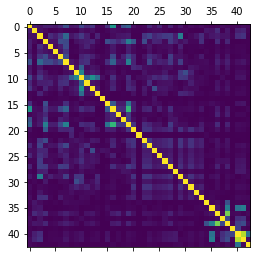

In [32]:
correlation = df.corr()
plt.matshow(abs(correlation))
plt.savefig('final_results/census/correlation_census.pdf')
plt.show()

In [33]:
correlation = abs(correlation)
correlation_ranking = correlation.mean().sort_values(ascending=False)
correlation_ranking.to_csv('final_results/census/correlation_ranking.csv')

In [179]:
df = df.sample(frac=1)

df_copy = df.copy()
df_positive_class = df_copy[(df_copy[census_bias] == 1)].copy()
df_negative_class = df_copy[(df_copy[census_bias] == 0)].copy()

rep_fraction = 0.12
bias_fraction = 0.05
negative_normal = len(df_negative_class)
positive_normal = len(df_positive_class)


#-----------------Simulate non-representative data---------------------#
rep = pd.concat([df_negative_class.head(int(negative_normal * 0.2)),
                df_positive_class.head(int(positive_normal * 0.2))],
                ignore_index=True) 

nonrep_more_negative_class = pd.concat([df_negative_class.tail(int(negative_normal * rep_fraction)), 
                             df_positive_class.tail(int(positive_normal * (rep_fraction - bias_fraction)))],
                            ignore_index=True)

nonrep_more_positive_class = pd.concat([df_negative_class.tail(int(negative_normal * (rep_fraction - bias_fraction))),
                             df_positive_class.tail(int(positive_normal * rep_fraction))], 
                             ignore_index=True)


#-----------------Simulate representative data---------------------#
rep2 = pd.concat([df_negative_class.tail(int(negative_normal * rep_fraction)),
                 df_positive_class.tail(int(positive_normal * rep_fraction))], 
                 ignore_index=True) 

rep['label'] = 0
nonrep_more_negative_class['label'] = 1
nonrep_more_positive_class['label'] = 1
rep2['label'] = 1

print("Current setting:")
print('Rep: \n', rep[census_bias].value_counts())
print('Rep 2: \n', rep2[census_bias].value_counts())
print('nonrep_more_positive_class: \n', nonrep_more_positive_class[census_bias].value_counts())
print('nonrep_more_negative_class: \n', nonrep_more_negative_class[census_bias].value_counts())

census_nonrep_more_negative_class = pd.concat([rep.copy(deep=True), nonrep_more_negative_class.copy(deep=True)])
census_nonrep_more_positive_class = pd.concat([rep.copy(deep=True), nonrep_more_positive_class.copy(deep=True)])
census_rep = pd.concat([rep.copy(deep=True), rep2.copy(deep=True)])

Current setting:
Rep: 
 0    3141
1    2891
Name: Marital Status_Married, dtype: int64
Rep 2: 
 0    1884
1    1734
Name: Marital Status_Married, dtype: int64
Nonrep_more_older: 
 1    1734
0    1099
Name: Marital Status_Married, dtype: int64
nonrep_more_younger: 
 0    1884
1    1011
Name: Marital Status_Married, dtype: int64


## Experiment 1 a)


### Simulate non-representative data. More younger than in R

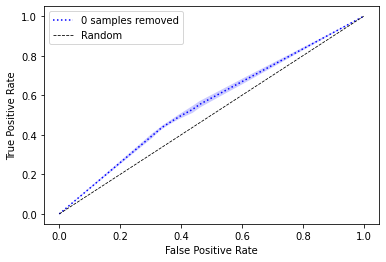

  0%|          | 0/114 [00:00<?, ?it/s]

auc 0.5226395035344026
temperature 0.28754827305607855
graph auc: 0.5582521854277002
auc 0.5167738957846191
temperature 0.2907743573184595
graph auc: 0.5544528921752084
auc 0.5132253348281922
temperature 0.2927260658444943
graph auc: 0.5552299933978584
auc 0.5134693866753203
temperature 0.29259183732857386
graph auc: 0.5536915129461877
auc 0.516024405318326
temperature 0.2911865770749207
graph auc: 0.5540772901092726


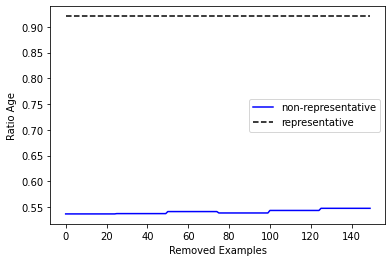

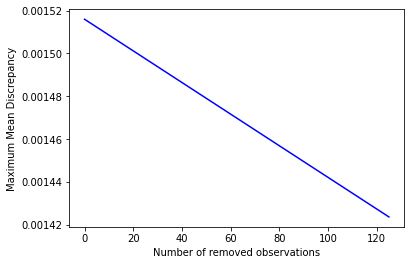

auc 0.5044242379990233
temperature 0.2975666691005372
graph auc: 0.558111537407906
auc 0.4938326496692805
temperature 0.29660795731810424
graph auc: 0.5552611387682024
auc 0.5074536296614136
temperature 0.2959005036862225
graph auc: 0.5536019873579031
auc 0.4940485007603234
temperature 0.2967266754181779
graph auc: 0.5500633483691846
auc 0.49142327064644
temperature 0.295282798855542
graph auc: 0.5490291157273659


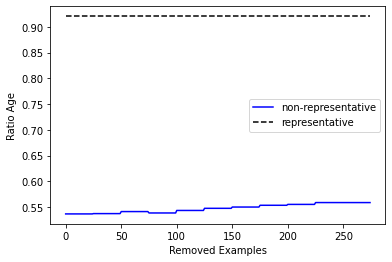

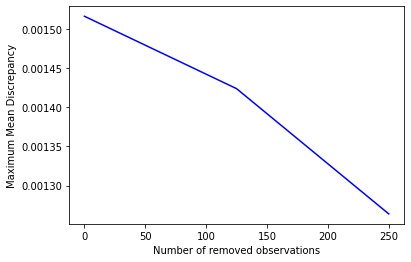

auc 0.48992217937853816
temperature 0.294457198658196
graph auc: 0.5509794420501283
auc 0.5012895600056695
temperature 0.29929074199688177
graph auc: 0.5481116523232878
auc 0.49750566024235543
temperature 0.29862811313329546
graph auc: 0.5528352577305842
auc 0.4865377519635872
temperature 0.2925957635799729
graph auc: 0.5430931013880927
auc 0.4763408514119848
temperature 0.2869874682765916
graph auc: 0.5448554166292371


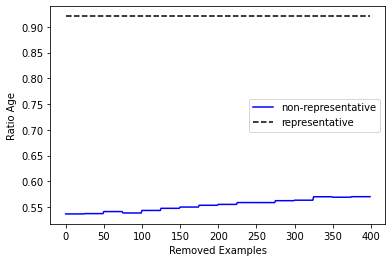

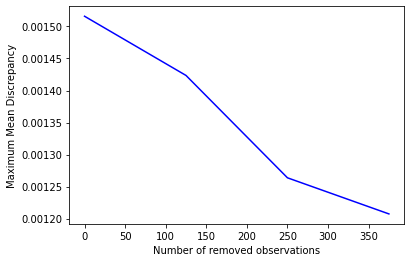

auc 0.48774068065555143
temperature 0.29325737436055327
graph auc: 0.5362857363855725
auc 0.48047547349340586
temperature 0.2892615104213732
graph auc: 0.5335723466441372
auc 0.47366924311901976
temperature 0.28551808371546084
graph auc: 0.5370165646894419
auc 0.47880903077248543
temperature 0.288344966924867
graph auc: 0.5482148998616849
auc 0.4659052203674069
temperature 0.2812478712020738
graph auc: 0.5402285232048456


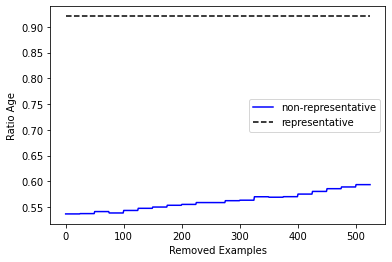

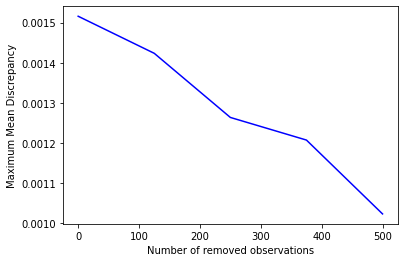

auc 0.46907620041753656
temperature 0.2829919102296451
graph auc: 0.5434236773059672
auc 0.4620343750349753
temperature 0.2791189062692364
graph auc: 0.5296896794333222
auc 0.4578031239218836
temperature 0.27679171815703596
graph auc: 0.526174839035356
auc 0.45833921670630196
temperature 0.2770865691884661
graph auc: 0.5240144669270786
auc 0.4616574348572321
temperature 0.2789115891714776
graph auc: 0.5172440136879034


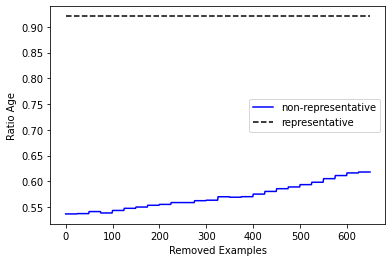

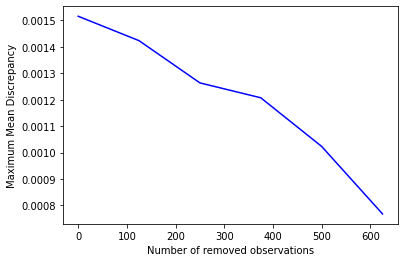

auc 0.4465781251825798
temperature 0.2706179688504189
graph auc: 0.5365462237712337
auc 0.4503773859386907
temperature 0.27270756226627985
graph auc: 0.5272775508323122
auc 0.4437868530002151
temperature 0.2690827691501183
graph auc: 0.535520087812024
auc 0.44645546455351265
temperature 0.27055050550443194
graph auc: 0.5298388347271566
auc 0.4315297675072425
temperature 0.26234137212898334
graph auc: 0.5166902802752139


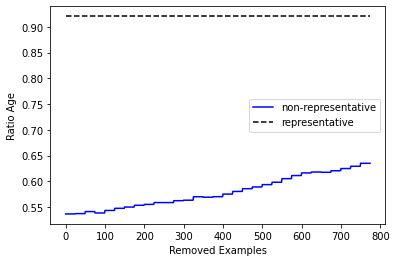

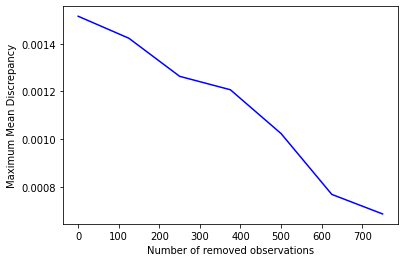

auc 0.43872416266315467
temperature 0.26629828946473505
graph auc: 0.5122988733519461
auc 0.4419838299509533
temperature 0.2680911064730243
graph auc: 0.5244838020589256
auc 0.4403727455163551
temperature 0.26720501003399527


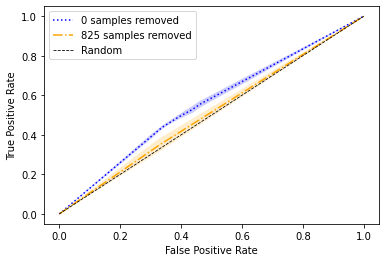

graph auc: 0.5160139141952187
auc 0.4399806106562103
temperature 0.26698933586091567
graph auc: 0.5252245332132146
auc 0.4411537407664421
temperature 0.26763455742154313
graph auc: 0.5206852599528708


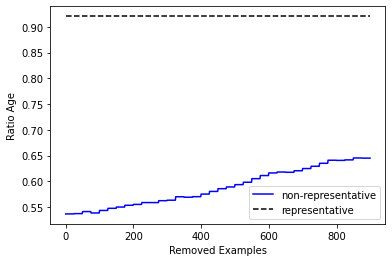

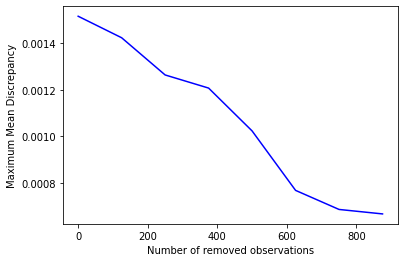

auc 0.4341946910208262
temperature 0.26380708006145437
graph auc: 0.5270770925356867
auc 0.4345330335121623
temperature 0.2639931684316893
graph auc: 0.5132899377899
auc 0.4184160787138645
temperature 0.2551288432926255
graph auc: 0.5176758317178394
auc 0.43608573469346
temperature 0.264847154081403
graph auc: 0.5249838999304087
auc 0.4303126381520778
temperature 0.26167195098364276
graph auc: 0.5064906339017314


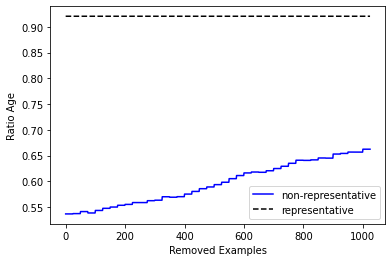

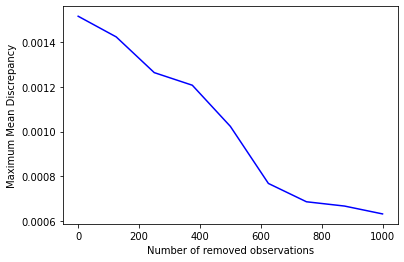

auc 0.4278487468768153
temperature 0.2603168107822484
graph auc: 0.5160059772439053
auc 0.42287093611256904
temperature 0.257579014861913
graph auc: 0.5081401933422319
auc 0.4240134818456938
temperature 0.25820741501513156
graph auc: 0.5284403986256674
auc 0.43293437745941066
temperature 0.26311390760267583
graph auc: 0.504483617197208
auc 0.42869196227363077
temperature 0.2607805792504969
graph auc: 0.5


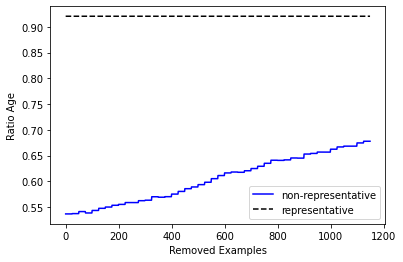

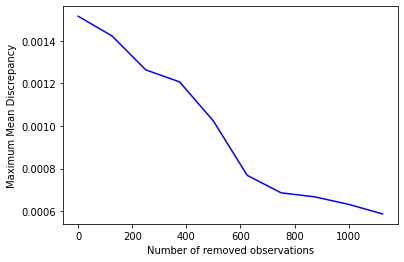

auc 0.4097636054039473
temperature 0.250369982972171
graph auc: 0.5067414039809506
auc 0.415374639933725
temperature 0.2534560519635487
graph auc: 0.5179298701830691
auc 0.4159888540188761
temperature 0.2537938697103818
graph auc: 0.5112446616475147
auc 0.42398843337010866
temperature 0.25819363835355974
graph auc: 0.5149414283585406
auc 0.41369249233628236
temperature 0.2525308707849553
graph auc: 0.5178953652675272


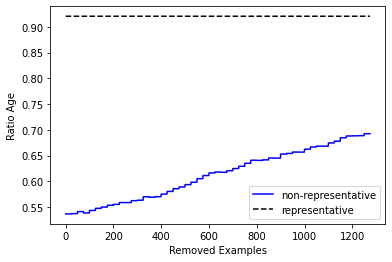

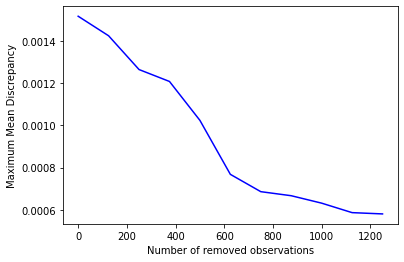

auc 0.41402207477042396
temperature 0.2527121411237332
graph auc: 0.5123395763213452
auc 0.4131466028915741
temperature 0.25223063159036574
graph auc: 0.5212423897727204
auc 0.4258373834845297
temperature 0.2592105609164913
graph auc: 0.5057963366561301
auc 0.42763488570511415
temperature 0.26019918713781276
graph auc: 0.5033111143312563
auc 0.40381240718326417
temperature 0.24709682395079527
graph auc: 0.5232121394763128


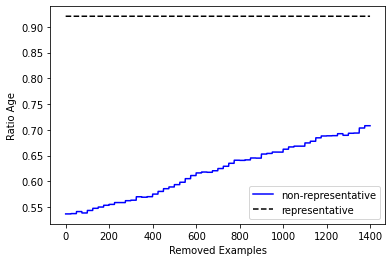

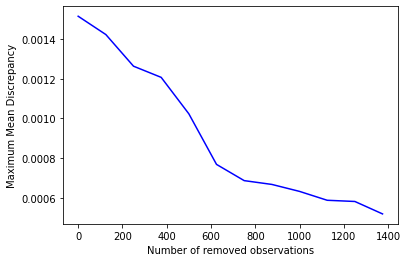

auc 0.40291030076434453
temperature 0.24660066542038947
graph auc: 0.5133710968083736
auc 0.3940611055419036
temperature 0.24173360804804697
graph auc: 0.5135132982490173
auc 0.40534682374275977
temperature 0.24794075305851787
graph auc: 0.5007456948246082
auc 0.4139783324002093
temperature 0.2526880828201151
graph auc: 0.5220831083466951
auc 0.4101272088766018
temperature 0.25056996488213096
graph auc: 0.5126087675492348


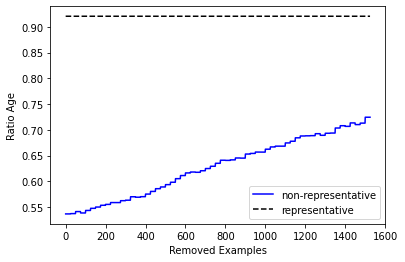

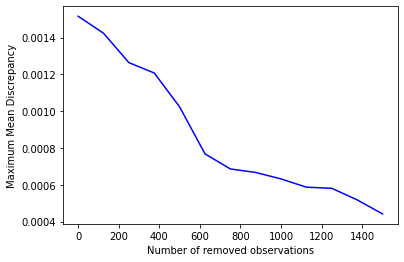

auc 0.40229706796725706
temperature 0.24626338738199138
graph auc: 0.5050804612993548
auc 0.4044917374973378
temperature 0.24747045562353578
graph auc: 0.5
auc 0.39035540315344186
temperature 0.239695471734393
graph auc: 0.5186641795416481
auc 0.403354018467165
temperature 0.24684471015694073
graph auc: 0.5086931643461339
auc 0.3983849968763762
temperature 0.24411174828200688
graph auc: 0.5198569828760894


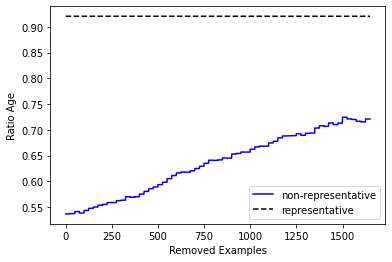

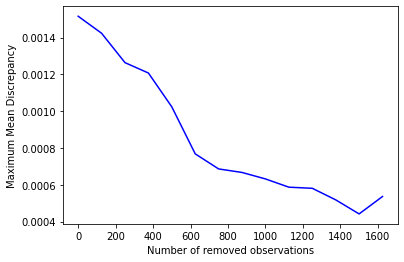

auc 0.3785981327930826
temperature 0.23322897303619539


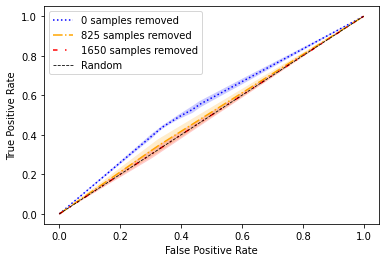

graph auc: 0.5056557630688454
auc 0.3988292027526552
temperature 0.24435606151396036
graph auc: 0.5
auc 0.39166698373700914
temperature 0.24041684105535502
graph auc: 0.5
auc 0.394942038555875
temperature 0.24221812120573125
graph auc: 0.5032830196449753
auc 0.38606442279353426
temperature 0.23733543253644382
graph auc: 0.5005108887893035


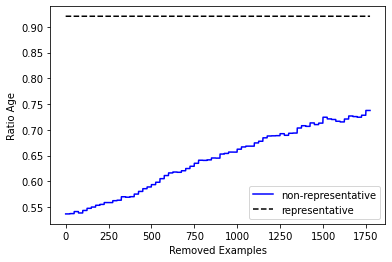

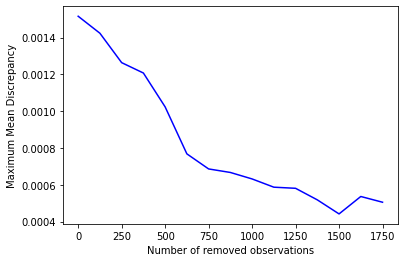

auc 0.38787941748809834
temperature 0.2383336796184541
graph auc: 0.4981732305598296
auc 0.3985403739579387
temperature 0.24419720567686626
graph auc: 0.4821872373293351
auc 0.3836114542833957
temperature 0.2359862998558676
graph auc: 0.49401667674090605
auc 0.3871647939958849
temperature 0.23794063669773668
graph auc: 0.4974229276588322
auc 0.389687932303631
temperature 0.23932836276699704
graph auc: 0.49526997366110626


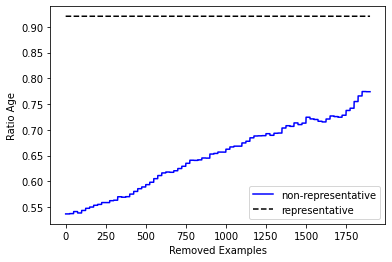

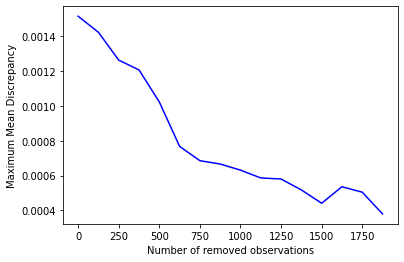

auc 0.3781432848338274
temperature 0.23297880665860507
graph auc: 0.4945854186951194
auc 0.36585255521640025
temperature 0.22621890536902012
graph auc: 0.49983416252072965
auc 0.3862888477945801
temperature 0.23745886628701907
graph auc: 0.4912936072157227
auc 0.37405346090690916
temperature 0.23072940349880003
graph auc: 0.49784726728675455
auc 0.36896912120862646
temperature 0.22793301666474453
graph auc: 0.49672012216399297


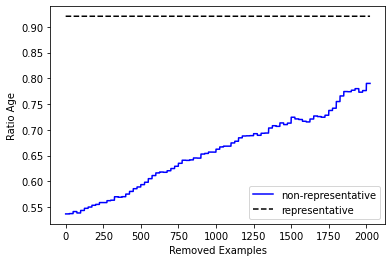

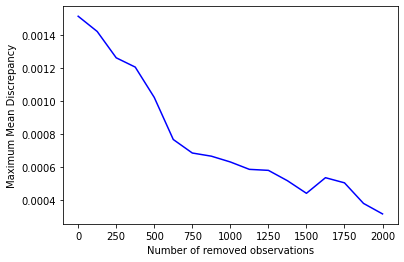

auc 0.361559022272276
temperature 0.22385746224975178
graph auc: 0.4997199083164743
auc 0.3651319399981707
temperature 0.22582256699899383
graph auc: 0.4928792919034022
auc 0.36419225668230976
temperature 0.22530574117527036
graph auc: 0.48701826804372733
auc 0.37978626188781783
temperature 0.23388244403829977
graph auc: 0.4907797397208877
auc 0.3771622624826919
temperature 0.23243924436548052
graph auc: 0.5


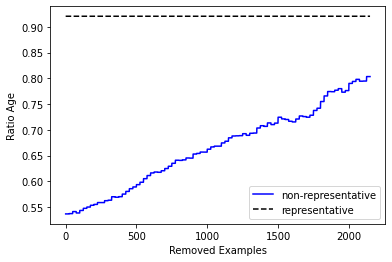

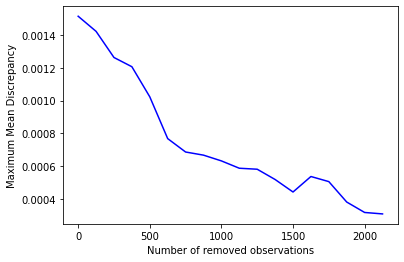

auc 0.3463625813841331
temperature 0.21549941976127318
graph auc: 0.4938167106302938
auc 0.37206954408701687
temperature 0.22963824924785925
graph auc: 0.49956848936757803
auc 0.3386528790893015
temperature 0.2112590834991158
graph auc: 0.5
auc 0.3565685647768257
temperature 0.22111271062725413
graph auc: 0.5000829187396352
auc 0.36353205788035947
temperature 0.2249426318341977
graph auc: 0.5


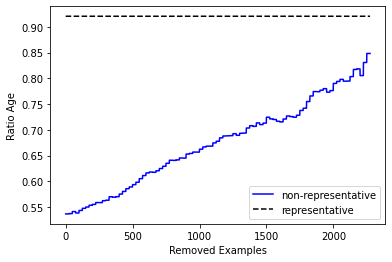

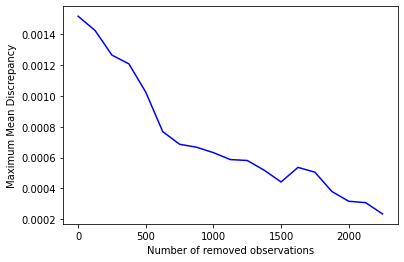

auc 0.3520662410297534
temperature 0.21863643256636436
graph auc: 0.49147675600492163
auc 0.36362678617267047
temperature 0.22499473239496875
graph auc: 0.5
auc 0.3339554588413616
temperature 0.20867550236274884
graph auc: 0.5
auc 0.3608251605472568
temperature 0.2234538383009912
graph auc: 0.4936520465152682
auc 0.35122952814347946
temperature 0.2181762404789137
graph auc: 0.4764313298504398


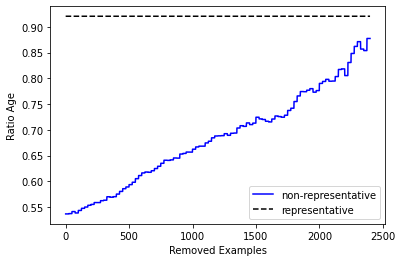

In [ ]:
drop = 25
number_of_splits = 5
test_size = 0.2
cv = 5
mmd_iteration = 5
number_of_iterations = int(len(census_nonrep_more_negative_class[census_nonrep_more_negative_class['label'] == 1]) 
                           / drop) - 1
representative_ratio = (len(census_rep[census_rep[census_bias] == 1]) 
                        / len(census_rep[census_rep[census_bias] == 0]))
result_dir = os.path.join(os.getcwd(), 'results/census_nonrep_more_negative_class',  
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(result_dir, exist_ok=True)
save = True

ratio, auc_more_negativ, roc, mrs, mmds, mrs_iteration = repeated_MRS(census_nonrep_more_negative_class,
                                                                      census_columns,
                    number_of_splits = number_of_splits, n_drop = drop,
                           test_size = test_size, cv = cv, us = True, directory=result_dir, 
                                             census_bias=census_bias, 
                                             number_of_iterations=number_of_iterations, 
                                                                    mmd_iteration=mmd_iteration)
    
file_name = os.path.join(result_dir, 'ratio_more_negative_class' + census_bias)
plot_class_ratio(ratio, representative_ratio, file_name, save=save)   
plot_auc(auc_more_negativ, drop, f'{file_name}_auc', save=save, mrs_iteration=mrs_iteration)
plot_mmds(mmds, drop, mmd_iteration, f'{file_name}_mmd', save)

### Save results

In [ ]:
pickle.dump(ratio, open("results/ratio_more_negative_class", 'wb'))
pickle.dump(representative_ratio, open("results/representative_ratio_more_negative_class", 'wb'))
pickle.dump(auc_more_negativ, open("results/auc_more_negative_class", 'wb'))
pickle.dump(mmds, open("results/mmd_more_negative_class", 'wb'))
pickle.dump(mrs_iteration, open("results/more_negative_class_mrs_iterations", 'wb'))

### Load results

In [ ]:
ratio_more_negative_class = pickle.load(open("results/ratio_more_negative_class", 'rb'))
representative_ratio_more_negative_class = pickle.load(open(
    "results/representative_ratio_more_negative_class", 'rb'))
auc_more_negativ = pickle.load(open("results/auc_more_negativ", 'rb'))
mmds_more_negativ = pickle.load(open("results/mmd_more_younger", 'rb'))
more_negative_class_mrs_iterations = pickle.load(open("results/more_negative_class_mrs_iterations", 'rb'))

### Visualise results

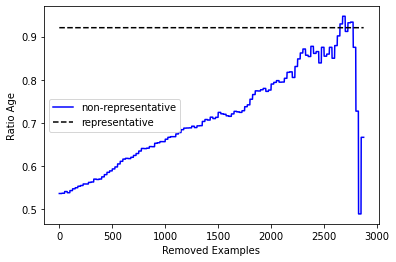

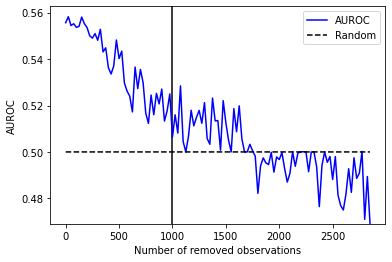

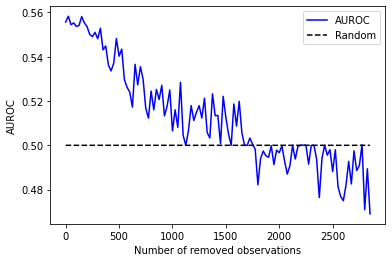

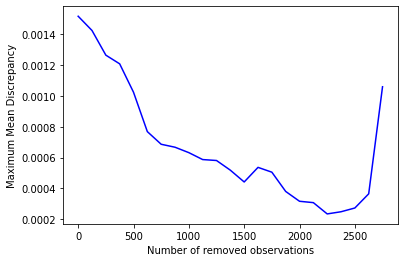

In [192]:
save = True
file_directory = os.path.join(os.getcwd(), "final_results/census/more_negativ/")
os.makedirs(file_directory, exist_ok=True)

plot_class_ratio(ratio_more_negative_class, representative_ratio_more_negative_class, 
                 file_directory+'ratio_more_negative', save=save)
plot_auc(auc_more_negativ, drop, file_directory+'auc_more_negative', save=save, 
         mrs_iteration=more_negative_class_mrs_iterations)
plot_auc(auc_more_negativ, drop, file_directory+'auc_more_negative', save=save, mrs_iteration=None)

plot_mmds(mmds_more_negativ, drop, mmd_iteration, file_directory+'mmd_more_negative', save)

## Experiment 1 b)


### Simulate non-representative data. More older than in R

In [ ]:
drop = 25
number_of_splits = 5
test_size = 0.2
mmd_iteration = 5
number_of_iterations = int(len(census_nonrep_more_positive_class[census_nonrep_more_positive_class['label'] == 1]) 
                           / drop) - 1
representative_ratio = (len(census_rep[census_rep[census_bias] == 1])
                        / len(census_rep[census_rep[census_bias] == 0]))
result_dir = os.path.join(os.getcwd(), 'results/census_nonrep_more_positive_class',  
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(result_dir, exist_ok=True)
save = True
cv = 5

ratio, auc_more_positive_class, roc, mrs, mmds, mrs_iteration = repeated_MRS(census_nonrep_more_positive_class, census_columns,
                                                   number_of_splits = number_of_splits, n_drop = drop,
                                                   test_size = test_size, cv = cv, us = True, 
                                                   directory=result_dir, 
                                                   census_bias=census_bias, 
                                                   number_of_iterations=number_of_iterations, 
                                                                    mmd_iteration=mmd_iteration)
    

file_name = os.path.join(result_dir,  'ratio_more_positive_class' + census_bias)
plot_class_ratio(ratio, representative_ratio, file_name, save=save) 
plot_auc(auc_more_positive_class, drop, file_name + '_auc', save=save)
plot_mmds(mmds, drop, mmd_iteration, f'{file_name}_mmd', save)

### Save results

In [ ]:
pickle.dump(ratio, open("results/ratio_more_positive_class", 'wb'))
pickle.dump(representative_ratio, open("results/representative_ratio_more_positive_class", 'wb'))
pickle.dump(auc_more_positive_class, open("results/auc_more_positive_class", 'wb'))
pickle.dump(mmds, open("results/mmd_more_positive_class", 'wb'))
pickle.dump(mrs_iteration, open("results/more_positive_class_mrs_iterations", 'wb'))

### Load results

In [ ]:
ratio_more_positive = pickle.load(open("results/ratio_more_positive", 'rb'))
representative_ratio_more_positive = pickle.load(open("results/representative_ratio_more_positive", 'rb'))
auc_more_positive_class = pickle.load(open("results/auc_more_positive_class", 'rb'))
mmd_more_positive = pickle.load(open("results/mmd_more_positive", 'rb'))
more_positive_mrs_iterations = pickle.load(open("results/more_positive_mrs_iterations", 'rb'))

### Visualise results

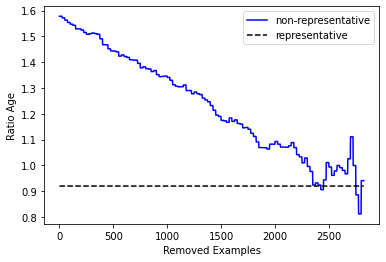

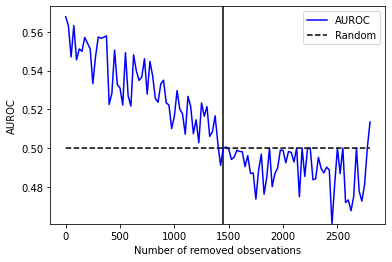

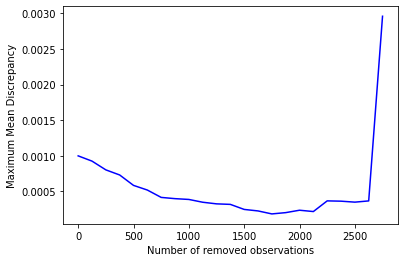

In [193]:
save = True
file_directory = os.path.join(os.getcwd(), "final_results/census/more_positive/")
os.makedirs(file_directory, exist_ok=True)

plot_class_ratio(ratio_more_positive, representative_ratio_more_positive,
                 file_directory+'ratio_more_positive', save=save)
plot_auc(auc_more_positive_class, drop, file_directory+'auc_more_positive', save=save,
         mrs_iteration=more_positive_mrs_iterations)
plot_mmds(mmd_more_positive, drop, mmd_iteration, file_directory+'mmd_more_positive', save)

## Experiment 1 c)


### Simulate already representative data

In [ ]:
drop = 25
number_of_splits = 5
test_size = 0.2
number_of_iterations = int(len(census_rep[census_rep['label'] == 1]) 
                           / drop) - 1
representative_ratio = (len(census_rep[census_rep[census_bias] == 1]) / len(census_rep[census_rep[census_bias] == 0]))
result_dir = os.path.join(os.getcwd(), 'results/census_rep',  datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(result_dir, exist_ok=True)
cv = 3
mmd_iteration = 5
save = True

ratio, auc_same, roc, new_same, mmds, mrs_iteration = repeated_MRS(census_rep, census_columns,
                    number_of_splits = number_of_splits, n_drop = drop,
                           test_size = test_size, cv = cv, us = True, directory=result_dir, 
                                            census_bias=census_bias, 
                                            number_of_iterations=number_of_iterations, 
                                                                    mmd_iteration=mmd_iteration)
    
file_name = os.path.join(result_dir, 'ratio_rep'  + census_bias)
plot_class_ratio(ratio, representative_ratio, file_name, save=True) 
plot_auc(auc_same, drop, file_name + '_auc', save=True, mrs_iteration=mrs_iteration)
plot_mmds(mmds, drop, mmd_iteration, f'{file_name}_mmd', save)

### Save results

In [ ]:
pickle.dump(ratio, open("results/ratio_same", 'wb'))
pickle.dump(representative_ratio, open("results/representative_ratio_same", 'wb'))
pickle.dump(auc_same, open("results/auc_same", 'wb'))
pickle.dump(mmds, open("results/mmd_same", 'wb'))
pickle.dump(mrs_iteration, open("results/same_mrs_iterations", 'wb'))
pickle.dump(drop, open("results/same_drop", 'wb'))

### Load results

In [ ]:
ratio_same = pickle.load(open("results/ratio_same", 'rb'))
representative_ratio_same = pickle.load(open("results/representative_ratio_same", 'rb'))
auc_same = pickle.load(open("results/auc_same", 'rb'))
mmd_same = pickle.load(open("results/mmd_same", 'rb'))
same_mrs_iterations = pickle.load(open("results/same_mrs_iterations", 'rb'))
same_drop = pickle.load(open("results/same_drop", 'rb'))

### Visualise results

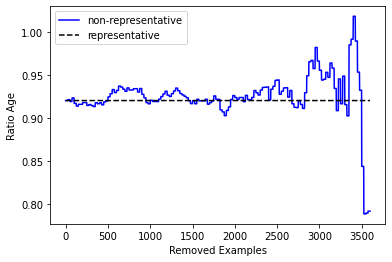

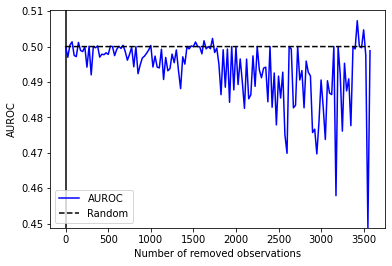

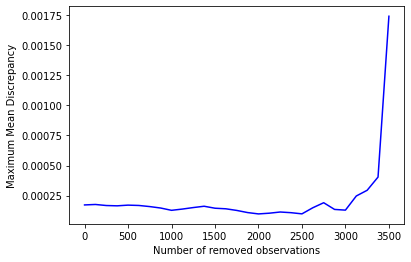

In [198]:
save = True
file_directory = os.path.join(os.getcwd(), "final_results/census/same/")
os.makedirs(file_directory, exist_ok=True)

plot_class_ratio(ratio_same, representative_ratio_same, file_directory+'ratio_same', save=save)
plot_auc(auc_same, same_drop, file_directory+'auc_same', save=save, mrs_iteration=same_mrs_iterations)
plot_mmds(mmd_same, same_drop, mmd_iteration, file_directory+'mmd_same', save)

## Experiment 2
### <font color='darkgreen'>Allensbach</font>   <---MRS---> <font color='darkred'>GBS</font> <---MRS---> <font color='darkgreen'>GESIS</font> 

*Figure shows MRS concept on GBS and GESIS for experiment 2 a). Replace Allensbach with GESIS for experiment 2 b)*

<img src="overview.PNG" width="450" height="450"/>


**Multivariate auxiliary information GESIS linked to GBS so that expected selection bias can be detected and corrected for. In addition, GBS contains an attribute for positive and negative treatment of survey participents for further analysis (Experiment 4).**


## Experiment 2 a)
### <font color='darkgreen'>Allensbach Studie - Institut für Demoskopie(IfD)</font>  <a name="us"></a>

### <font color='darkred'>Important note:</font>  <a name="allensbach"></a> Allensbach is already merged with GBS in this data set


In [11]:
allensbach = pd.read_csv(os.path.join(path, 'data/allensbach_mrs.csv'))
allensbach.drop(['Unnamed: 0'], axis=1, inplace=True)
allensbach_columns = ['Alter', 'Berufsgruppe', 'Erwerbstaetigkeit', 'Geschlecht',
                      'Optimismus', 'Pessimismus', 'Schulabschluss', 'woechentlicheArbeitszeit', 'Resilienz']

allensbach_scaler = StandardScaler()
scaled_allensbach = allensbach.copy(deep=True)
scaled_allensbach[allensbach_columns] = allensbach_scaler.fit_transform(scaled_allensbach[allensbach_columns])

In [12]:
drop = 5
number_of_splits = 5
repetetions = 10
cv = 5
result_dir_allensbach = os.path.join(os.getcwd(), 'results/gbs_allensbach', 
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(result_dir_allensbach, exist_ok=True)

test_size = 0.3
number_of_iterations = int(len(scaled_allensbach[scaled_allensbach['label']  == 1]) / drop)

aucs = []
rocs = []
mmds = []
mmd_iteration = 5
mrs_iterations = []

for _ in tqdm(range(repetetions)):
    auc, roc, mrs, mmd, mrs_iteration = repeated_MRS(scaled_allensbach, allensbach_columns,
                     number_of_splits=number_of_splits,
                        n_drop=drop, test_size=test_size, cv=cv, directory=result_dir_allensbach)
    aucs.append(auc)
    rocs.append(roc)
    mmds.append(mmd)
    mrs_iterations.append(mrs_iteration)
    
    median_rocs = calculate_median_rocs(rocs)
    median_mmds = np.median(mmds, axis = 0)
    std_mmds = np.std(mmds, axis = 0)
    median_aucs = np.median(aucs, axis = 0)
    std_aucs = np.std(aucs, axis = 0)
    
    plot_auc_median(median_aucs, std_aucs, drop, '', save=False, mrs_iteration=mrs_iterations)
    plot_mmds_median(median_mmds, std_mmds, drop, mmd_iteration, '', save=False)
    plot_rocs(median_rocs, '', save=False)
     
plot_auc_median(median_aucs, std_aucs, drop, result_dir_allensbach + "/median_aucs" , 
                save=True, mrs_iteration=mrs_iterations)
plot_rocs(median_rocs, result_dir_allensbach + "/median_rocs", save=True)
plot_mmds_median(median_mmds, std_mmds, drop, mmd_iteration, result_dir_allensbach + "/median_mmds", save=True)

    
pickle.dump(median_aucs, open(result_dir_allensbach + "/median_aucs", 'wb'))
pickle.dump(std_aucs, open(result_dir_allensbach + "/std_aucs", 'wb'))
pickle.dump(median_rocs, open(result_dir_allensbach + "/median_roc", 'wb'))
pickle.dump(median_mmds, open(result_dir_allensbach + "/median_mmds", 'wb'))
pickle.dump(std_mmds, open(result_dir_allensbach + "/std_mmds", 'wb'))

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Save results

In [ ]:
pickle.dump(median_aucs, open("results/allensbach_median_aucs", 'wb'))
pickle.dump(std_aucs, open("results/allensbach_std_aucs", 'wb'))
pickle.dump(median_rocs, open("results/allensbach_median_rocs", 'wb'))

pickle.dump(median_mmds, open("results/allensbach_median_mmds", 'wb'))
pickle.dump(std_mmds, open("results/allensbach_std_mmds", 'wb'))
pickle.dump(mrs_iterations, open("results/allensbach_mrs_iterations", 'wb'))
pickle.dump(drop, open("results/allensbach_drop", "wb"))
pickle.dump(mmd_iteration, (open("results/allensbach_mmd_iteration", 'wb')))

### Load  results

In [ ]:
allensbach_median_aucs = pickle.load(open("results/allensbach_median_aucs", "rb"))
allensbach_std_aucs = pickle.load(open("results/allensbach_std_aucs", "rb"))
allensbach_rocs = pickle.load(open("results/allensbach_median_rocs", "rb"))
allensbach_mrs_iterations =  pickle.load(open("results/allensbach_mrs_iterations", 'rb'))
allensbach_median_mmds =  pickle.load(open("results/allensbach_median_mmds", 'rb'))
allensbach_std_mmds =  pickle.load(open("results/allensbach_std_mmds", 'rb'))
allensbach_drop = pickle.load(open("results/allensbach_drop", 'rb'))
allensbach_mmd_iteration = pickle.load(open("results/allensbach_mmd_iteration", 'rb'))

### Visualise results

In [ ]:
save = True
file_directory = os.path.join(os.getcwd(), "final_results/allensbach/")
os.makedirs(file_directory, exist_ok=True)

plot_auc_median(allensbach_median_aucs, allensbach_std_aucs, allensbach_drop, 
                file_directory+"allensbach_auc", save=save, 
                mrs_iteration=None)
plot_auc_median(allensbach_median_aucs, allensbach_std_aucs, allensbach_drop, 
                file_directory+"allensbach_auc_with_iterations", save=save, 
                mrs_iteration=allensbach_mrs_iterations)
plot_rocs(allensbach_rocs, file_directory+"allensbach_rocs", save=save)
plot_mmds_median(allensbach_median_mmds, allensbach_std_mmds, allensbach_drop, allensbach_mmd_iteration, 
                 file_directory + "median_mmds_allensbach", save=save)

### Experiment 2 b)


### <font color='darkgreen'>Load Gesis</font>  <a name="us"></a>

In [ ]:
gesis = pd.read_csv(os.path.join(path, 'data/gesis_processed.csv'), engine='python')
gbs = pd.read_csv(os.path.join(path, 'data/gbs_processed.csv'), engine='python')

gesis_columns = ['Geschlecht', 'Geburtsjahr', 'Geburtsland',
       'Nationalitaet', 'Familienstand', 'Hoechster Bildungsabschluss',
       'Berufliche Ausbildung', 'Erwerbstaetigkeit', 'Nettoeinkommen Selbst',
       'Zufriedenheit Wahlergebnis', 'Gesellig', 'Andere kritisieren',
       'Gruendlich', 'Nervoes', 'Phantasievoll', 'Berufsgruppe', 'Wahlteilnahme', 'BRS6']

N = gbs.copy()
R = gesis.copy()

N['label'] = 1
R['label'] = 0

gesis_gbs = pd.concat([N, R], ignore_index=True)

In [ ]:
gesis_scaler = StandardScaler()
scaled_gesis_gbs = gesis_gbs.copy(deep=True)
scaled_gesis_gbs[gesis_columns] = gesis_scaler.fit_transform(scaled_gesis_gbs[gesis_columns])

In [ ]:
drop = 5
number_of_splits = 5
cv = 5
result_dir_gesis = os.path.join(os.getcwd(), 'results/gbs_gesis',  
                                datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

test_size = 0.3
repetetions = 10
number_of_iterations = int(len(scaled_gesis_gbs[scaled_gesis_gbs['label'] == 1]) / drop) 

os.makedirs(result_dir_gesis, exist_ok=True)
aucs = []
rocs = []
mmds = []
mmd_iteration = 5
mrs_iterations = []

for _ in tqdm(range(repetetions)):
    auc, roc, mrs, mmd, mrs_iteration = repeated_MRS(scaled_gesis_gbs, gesis_columns, 
                                                     number_of_splits=number_of_splits,
                        n_drop=drop, test_size=test_size, cv=cv, directory=result_dir_gesis,
                                             number_of_iterations=number_of_iterations)
    aucs.append(auc)
    rocs.append(roc)
    mmds.append(mmd)
    mrs_iterations.append(mrs_iteration)
    
    median_rocs = calculate_median_rocs(rocs)
    median_mmds = np.median(mmds, axis = 0)
    std_mmds = np.std(mmds, axis = 0)
    median_aucs = np.median(aucs, axis = 0)
    std_aucs = np.std(aucs, axis=0)
    plot_rocs(median_rocs, '', save=False)
    plot_mmds_median(median_mmds, std_mmds, drop, mmd_iteration, '', save=False)
    plot_auc_median(median_aucs, std_aucs, drop, '', save=False, mrs_iteration=mrs_iterations)
    

plot_auc_median(median_aucs, std_aucs, drop, result_dir_gesis + "/median_aucs", save=True,
               mrs_iteration=mrs_iterations)
plot_rocs(median_rocs, result_dir_gesis + "/median_rocs", save=True)
plot_mmds_median(median_mmds, std_mmds, drop, mmd_iteration, result_dir_gesis + "/median_mmds", save=True)

pickle.dump(median_aucs, open(result_dir_gesis + "/median_aucs", 'wb'))
pickle.dump(std_aucs, open(result_dir_gesis + "/std_aucs", 'wb'))
pickle.dump(median_rocs, open(result_dir_gesis + "/median_rocs", 'wb'))
pickle.dump(median_mmds, open(result_dir_gesis + "/median_mmds", 'wb'))
pickle.dump(std_mmds, open(result_dir_gesis + "/std_mmds", 'wb'))
pickle.dump(mrs_iterations, open(result_dir_gesis + "/mrs_iterations", 'wb'))

### Save results

In [ ]:
pickle.dump(median_aucs, open("results/gesis_median_aucs", 'wb'))
pickle.dump(std_aucs, open("results/gesis_std_aucs", 'wb'))
pickle.dump(median_rocs, open("results/gesis_median_rocs", 'wb'))
pickle.dump(median_mmds, open("results/gesis_median_mmds", 'wb'))
pickle.dump(std_mmds, open("results/gesis_std_mmds", 'wb'))
pickle.dump(mrs_iterations, open("results/gesis_mrs_iterations", 'wb'))
pickle.dump(drop, open("results/gesis_drop", "wb"))
pickle.dump(mmd_iteration, (open("results/gesis_mmd_iteration", 'wb')))

### Load results

In [ ]:
gesis_median_aucs = pickle.load(open("results/gesis_median_aucs", 'rb'))
gesis_std_aucs = pickle.load(open("results/gesis_std_aucs", 'rb'))
gesis_median_rocs =  pickle.load(open("results/gesis_median_rocs", 'rb'))
gesis_mrs_iterations =  pickle.load(open("results/gesis_mrs_iterations", 'rb'))
gesis_median_mmds =  pickle.load(open("results/gesis_median_mmds", 'rb'))
gesis_std_mmds =  pickle.load(open("results/gesis_std_mmds", 'rb'))
gesis_drop = pickle.load(open("results/gesis_drop", 'rb'))
gesis_mmd_iteration = pickle.load(open("results/gesis_mmd_iteration", 'rb'))

### Visualise results

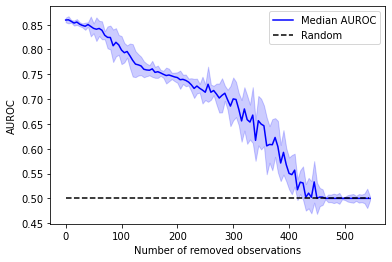

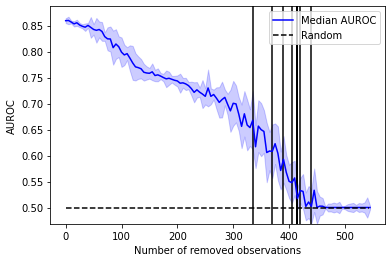

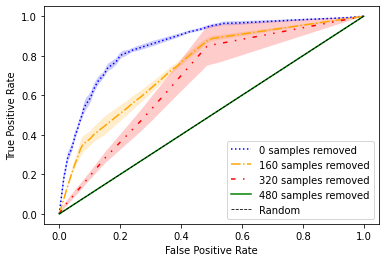

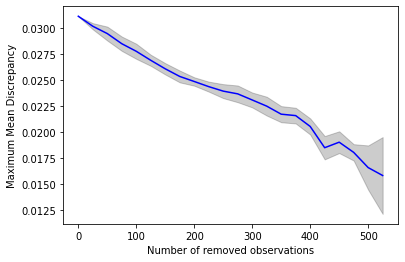

In [489]:
save = True
file_directory = os.path.join(os.getcwd(), "final_results/gesis/")
os.makedirs(file_directory, exist_ok=True)

plot_auc_median(gesis_median_aucs, gesis_std_aucs, gesis_drop, 
                file_directory+"gesis_auc", save=save, 
                mrs_iteration=None)
plot_auc_median(gesis_median_aucs, gesis_std_aucs, gesis_drop, 
                file_directory+"gesis_auc_with_iterations", save=save, 
                mrs_iteration=gesis_mrs_iterations)
plot_rocs(gesis_median_rocs, file_directory+"gesis_rocs", save=save)
plot_mmds_median(gesis_median_mmds, gesis_std_mmds, gesis_drop, gesis_mmd_iteration, 
                 file_directory + "median_mmds_gesis", save=save)

# Compare MRS with temperature sampling and sampling 

### Run experiment

In [ ]:
drop = 5
number_of_splits = 5
result_dir_temperature = os.path.join(os.getcwd(), 'results/temperature_comparison',  
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

cv= 5
test_size = 0.3
repetetions = 10
number_of_iterations = int(len(scaled_gesis_gbs[scaled_gesis_gbs['label'] == 1]) / drop)
os.makedirs(result_dir_temperature, exist_ok=True)
aucs_without_temperature = []
rocs_without_temperature = []
mmds_without_temperature = []
mrs_iterations = []
mmd_iteration = 5
    
for _ in tqdm(range(repetetions)):
    auc, roc, mrs, mmd, mrs_iteration = repeated_MRS(scaled_gesis_gbs, gesis_columns,
                     number_of_splits=number_of_splits,
                    n_drop=drop, test_size=test_size, cv=cv, directory=result_dir_temperature,
                                                 number_of_iterations=number_of_iterations, 
                                                     temperature_sampling=False)
    
    aucs_without_temperature.append(auc)
    rocs_without_temperature.append(roc)
    mmds_without_temperature.append(mmd)
    mrs_iterations.append(mrs_iteration)
    
    median_rocs = calculate_median_rocs(rocs_without_temperature)
    median_mmds = np.median(mmds_without_temperature, axis = 0)
    std_mmds = np.std(mmds_without_temperature, axis = 0)
    median_aucs = np.median(aucs_without_temperature, axis = 0)
    std_aucs = np.std(aucs_without_temperature, axis = 0)
    
    plot_mmds_median(median_mmds, std_mmds, drop, mmd_iteration, '', save=False)
    plot_auc_median(median_aucs, std_aucs, drop, '', save=False, mrs_iteration=mrs_iteration)
    plot_rocs(median_rocs, '', save=False)
    
plot_auc_median(median_aucs, std_aucs, drop, result_dir_temperature + "/median_aucs" , 
                save=True, mrs_iteration=mrs_iterations)
plot_rocs(median_rocs, result_dir_temperature + "/median_rocs", save=True)
plot_mmds_median(median_mmds, std_mmds, drop, mmd_iteration, result_dir_temperature + "/median_mmds", save=True)


pickle.dump(median_aucs, open(result_dir_temperature + "/median_aucs", 'wb'))
pickle.dump(std_aucs, open(result_dir_temperature + "/std_aucs", 'wb'))
pickle.dump(median_rocs, open(result_dir_temperature + "/median_rocs", 'wb'))
pickle.dump(median_mmds, open(result_dir_temperature + "/median_mmds", 'wb'))
pickle.dump(std_mmds, open(result_dir_temperature + "/std_mmds", 'wb'))

### Save results

In [ ]:
pickle.dump(median_aucs, open("results/median_aucs_without_temperature", 'wb'))
pickle.dump(std_aucs, open("results/std_aucs_without_temperature", 'wb'))
pickle.dump(median_rocs, open("results/median_rocs_without_temperature", 'wb'))
pickle.dump(median_mmds, open("results/median_mmds_without_temperature", 'wb'))
pickle.dump(std_mmds, open("results/std_mmds_without_temperature", 'wb'))
pickle.dump(mrs_iterations, open("results/mrs_iterations_without_temperature", 'wb'))
pickle.dump(drop, open("results/drop_without_temperature", 'wb'))
pickle.dump(mmd_iteration, open("results/mmd_iteration_without_temperature", 'wb'))

### Load saved results

In [ ]:
median_aucs_without_temperature = pickle.load(open("results/median_aucs_without_temperature", 'rb'))
std_aucs_without_temperature = pickle.load(open("results/std_aucs_without_temperature", 'rb'))
median_aucs_temperature = pickle.load(open("results/gesis_median_aucs", 'rb'))
std_aucs_temperature = pickle.load(open("results/gesis_std_aucs", 'rb'))

median_mmds_without_temperature = pickle.load(open("results/median_mmds_without_temperature", 'rb'))
std_mmds_without_temperature = pickle.load(open("results/std_mmds_without_temperature", 'rb'))
gesis_median_mmds = pickle.load(open("results/gesis_median_mmds", 'rb'))
gesis_std_mmds = pickle.load(open("results/gesis_std_mmds", 'rb'))

mrs_iterations_without_temperature = pickle.load(open("results/mrs_iterations_without_temperature", 'rb'))
drop_without_temperature = pickle.load(open("results/drop_without_temperature", 'rb'))
mmd_iteration_without_temperature = pickle.load(open("results/mmd_iteration_without_temperature", 'rb'))

### Visualise results

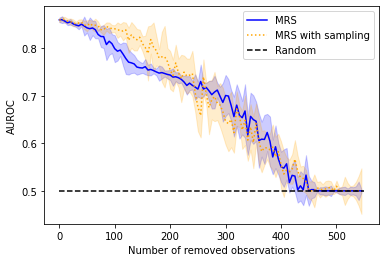

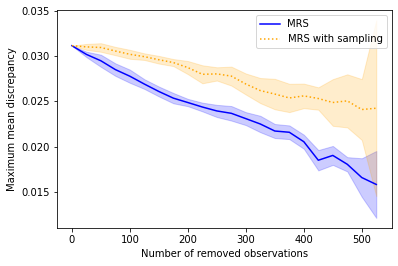

In [491]:
experiment_label = 'MRS with sampling'   
file_directory = os.path.join(os.getcwd(), "final_results/temperature_comparison/")
os.makedirs(file_directory, exist_ok=True)
save = True

plot_experiment_comparison_auc(median_aucs_temperature, std_aucs_temperature, median_aucs_without_temperature, 
                                std_aucs_without_temperature, experiment_label, 
                           drop_without_temperature, file_directory + 'aucs_temperature', save=save)   
plot_experiment_comparison_mmd(gesis_median_mmds, gesis_std_mmds,  median_mmds_without_temperature, 
                               std_mmds_without_temperature, 
                               experiment_label, drop_without_temperature, mmd_iteration_without_temperature, 
                               file_directory + 'mmds_temperature',  save=save)

# Compare MRS with cross-validation and without

In [ ]:
def MRS_without_cv(N: pd.DataFrame, R: pd.DataFrame, columns: list, number_of_splits = 5,
        n_drop: int=1, cv=5):
    EPSILON = 10e-16 # to avoid dividing by zero
    preds = []
    bootstrap_iterations = 25
    kf = KFold(n_splits=number_of_splits)
    bootstrap_predictions_n = np.zeros(len(N))
    bootstrap_predictions_r = np.zeros(len(R))
    counter_n = np.zeros(len(N))
    counter_r = np.zeros(len(R))
    
    n = min(len(R), len(N))
    for _ in range(bootstrap_iterations):
        n_sample = N.sample(n=n, replace=True)
        N_test = N.drop(n_sample.index)
        r_sample = R.sample(n=n, replace=True)
        R_test = R.drop(r_sample.index)
        locations_not_in_bootstrap_n = list(set([N.index.get_loc(index) for index in N_test.index]))
        locations_not_in_bootstrap_r = list(set([R.index.get_loc(index) for index in R_test.index]))
        
        bootstrap = pd.concat([n_sample, r_sample])
        clf = grid_search(bootstrap[columns], bootstrap.label, 5)
        proba_n = clf.predict_proba(N_test[columns])[:,1]
        proba_r = clf.predict_proba(R_test[columns])[:,1]
        bootstrap_single_n = np.zeros(len(N))
        bootstrap_single_n[list(locations_not_in_bootstrap_n)] = proba_n
        counter_n[list(locations_not_in_bootstrap_n)] += 1
        bootstrap_predictions_n += bootstrap_single_n
        
        bootstrap_single_r = np.zeros(len(R))
        bootstrap_single_r[list(locations_not_in_bootstrap_r)] = proba_r
        counter_r[list(locations_not_in_bootstrap_r)] += 1
        bootstrap_predictions_r += bootstrap_single_r
        
    counter_n = [EPSILON if x == 0 else x for x in counter_n]
    counter_r = [EPSILON if x == 0 else x for x in counter_r]
    preds_n = bootstrap_predictions_n / counter_n
    preds_r = bootstrap_predictions_r / counter_r
    
    all_preds = np.concatenate([preds_n, preds_r])
    all_true = np.concatenate([np.ones(len(preds_n)), np.zeros(len(preds_r))])
    auc = roc_auc_score(all_true, all_preds)
    mapped_auc = abs(auc - 0.5)
    temperature = -0.55 * mapped_auc + 0.3
    drop_ids = temperature_sample(preds_n, temperature, n_drop)
    return N.drop(N.index[drop_ids])



In [ ]:
def repeated_MRS_without_cv(df, columns, number_of_splits, n_drop=1,test_size=0.33, cv=5, us=False, directory='', 
                 census_bias='', temperature_sampling=True, number_of_iterations=None):
    
    N = df[df['label'] == 1].copy()
    R = df[df['label'] == 0].copy()
    if number_of_iterations is None:
        number_of_iterations = int(len(N) / drop)
    aucs = []
    rocs = []
    ratio = []
    mmds = []
    kl_values = []
    mmd_iteration = 5
    
    auroc_iteration = int(int(len(N) / n_drop) / 3.5) + 1
    
    if us:
        representative_ratio = (len(R[R[census_bias] == 1]) /
                                len(R[R[census_bias] == 0]))
        ratio.extend([len(N[N[census_bias] == 1]) / 
                         (len(N[N[census_bias] == 0]))]*drop)
        
    #start value
    auc, roc = auc_prediction(N, R, columns, test_size, drop, 0, cv, True)
    aucs.append(auc)
    rocs.append(roc)
    plot_rocs(rocs, '', save=False)
    mmds.append(maximum_mean_discrepancy(N[columns], R[columns]))
    
    best_auc = auc
    mrs_iteration = 0
    min_delta = 0.005
    mrs = N
    
    for i in tqdm(range(number_of_iterations)):
        N = MRS_without_cv(N, R, columns,
                                number_of_splits=number_of_splits,
                                n_drop=n_drop, cv=cv)
        
        if((i+1) % auroc_iteration == 0):
            auc, roc = auc_prediction(N, R, columns, test_size, drop, i+1, cv, calculate_roc=True)
            aucs.append(auc)
            rocs.append(roc)
            plot_rocs(rocs, '', save=False)
        else:
            auc, _ = auc_prediction(N, R, columns, test_size, drop, i+1, cv, calculate_roc=False)
            aucs.append(auc)
        
        if abs(auc - 0.5) < abs(best_auc - 0.5) - min_delta:
            best_auc = auc
            mrs_iteration = (i + 1) * n_drop
            mrs = N.copy(deep=True)
            
        
        if ((i+1) % mmd_iteration == 0):
            mmds.append(maximum_mean_discrepancy(N[columns], R[columns]))
            plot_mmds(mmds, drop, mmd_iteration, '', False)
            
        if len(N)-drop <= cv or len(N)-drop <= number_of_splits:
            break
    
    
    return aucs, rocs, mrs, mmds, mrs_iteration 

In [ ]:
drop = 5
number_of_splits = 5
result_dir_cv = os.path.join(os.getcwd(), 'results/cv__comparison',  
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

test_size = 0.3
number_of_iterations = int(len(scaled_gesis_gbs[scaled_gesis_gbs['label']  == 1]) / drop)
repetetions = 10
os.makedirs(result_dir_cv, exist_ok=True)
cv = 5
aucs_without_cv = [] 
aucs_without_cv = []
rocs_without_cv = []
mmds_without_cv = []
mrs_iterations = []
mmd_iteration = 5
save=False
    
for temp in tqdm(range(repetetions)):
    auc, roc, mrs, mmd, mrs_iteration = repeated_MRS_without_cv(scaled_gesis_gbs, gesis_columns, 
                    number_of_splits=number_of_splits,
                    n_drop=drop, test_size=test_size, cv=cv, number_of_iterations=number_of_iterations)
    
    aucs_without_cv.append(auc)
    rocs_without_cv.append(roc)
    mmds_without_cv.append(mmd)
    mrs_iterations.append(mrs_iteration)
    
    median_rocs = calculate_median_rocs(rocs_without_cv)
    median_mmds = np.median(mmds_without_cv, axis = 0)
    std_mmds = np.std(mmds_without_cv, axis = 0)
    median_aucs = np.median(aucs_without_cv, axis = 0)
    std_aucs = np.std(aucs_without_cv, axis = 0)
    
    plot_mmds_median(median_mmds, std_mmds, drop, mmd_iteration, '', save=save)
    plot_auc_median(median_aucs, std_aucs, drop, '', save=False, mrs_iteration=mrs_iteration)
    plot_rocs(median_rocs, '', save=save)


plot_auc_median(median_aucs, std_aucs, drop, result_dir_cv + "/median_aucs" , 
                save=True, mrs_iteration=mrs_iterations)
plot_rocs(median_rocs, result_dir_cv + "/median_rocs", save=save)
plot_mmds_median(median_mmds, std_mmds, drop, mmd_iteration, result_dir_cv + "/median_mmds", save=save)


pickle.dump(median_aucs, open(result_dir_cv + "/median_aucs", 'wb'))
pickle.dump(std_aucs, open(result_dir_cv + "/std_aucs", 'wb'))
pickle.dump(median_rocs, open(result_dir_cv + "/median_rocs", 'wb'))
pickle.dump(median_mmds, open(result_dir_cv + "/median_mmds", 'wb'))
pickle.dump(std_mmds, open(result_dir_cv + "/std_mmds", 'wb'))

### Save results

In [ ]:
pickle.dump(median_aucs, open("results/median_aucs_without_cv", 'wb'))
pickle.dump(std_aucs, open("results/std_aucs_without_cv", 'wb'))
pickle.dump(median_mmds, open("results/median_mmds_without_cv", 'wb'))
pickle.dump(std_mmds, open("results/std_mmds_without_cv", 'wb'))

pickle.dump(median_rocs, open("results/median_rocs_without_cv", 'wb'))
pickle.dump(std_mmds, open("results/std_mmds_without_cv", 'wb'))
pickle.dump(mrs_iterations, open("results/mrs_iterations_without_cv", 'wb'))

pickle.dump(drop, open("results/drop_without_cv", 'wb'))
pickle.dump(mmd_iteration, open("results/mmd_iteration_without_cv", 'wb'))

### Load results

In [ ]:
gesis_median_aucs = pickle.load(open("results/gesis_median_aucs", 'rb'))
gesis_std_aucs = pickle.load(open("results/gesis_std_aucs", 'rb'))
median_aucs_without_cv = pickle.load(open("results/median_aucs_without_cv", 'rb'))
std_aucs_without_cv = pickle.load(open("results/std_aucs_without_cv", 'rb'))

median_mmds_without_cv = pickle.load(open("results/median_mmds_without_cv", 'rb'))
std_mmds_without_cv = pickle.load(open("results/std_mmds_without_cv", 'rb'))
gesis_median_mmds = pickle.load(open("results/gesis_median_mmds", 'rb'))
gesis_std_mmds = pickle.load(open("results/gesis_std_mmds", 'rb'))

mrs_iterations_without_cv = pickle.load(open("results/mrs_iterations_without_cv", 'rb'))
drop_without_cv = pickle.load(open("results/drop_without_temperature", 'rb'))
mmd_iteration_without_cv = pickle.load(open("results/mmd_iteration_without_temperature", 'rb'))

### Visualise results

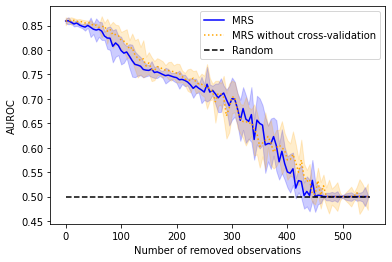

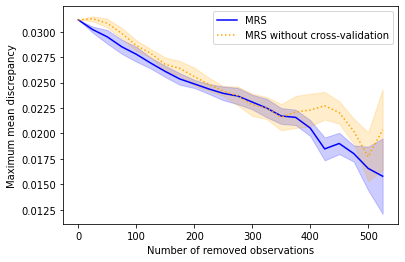

In [492]:
save = True
file_directory = os.path.join(os.getcwd(), "final_results/cross_validation_comparison/")
os.makedirs(file_directory, exist_ok=True)

experiment_label = 'MRS without cross-validation'


 
plot_experiment_comparison_auc(gesis_median_aucs, gesis_std_aucs, median_aucs_without_cv, 
                                std_aucs_without_cv, experiment_label, drop_without_cv, 
                           file_directory+'auc_cv', save=save)    
plot_experiment_comparison_mmd(gesis_median_mmds, gesis_std_mmds,  median_mmds_without_cv, 
                               std_mmds_without_cv, 
                               experiment_label, drop_without_cv, mmd_iteration_without_cv, 
                               file_directory+'mmd_cv',  save=save)

# Random drops

### Run experiment

In [ ]:
drop = 5
result_dir = os.path.join(os.getcwd(), 'results/random_drop',  
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
cv = 5
test_size = 0.3
repetetions = 10
number_of_splits = 5
aucs_random_drop = []
mmds = []
mrs_iterations = []
mmd_iteration = 5
os.makedirs(result_dir, exist_ok=True)

data = scaled_gesis_gbs
columns = gesis_columns
iterations = int(len(data[data['label'] == 1]) / drop) 

for _ in tqdm(range(repetetions)): 
    N = data[data['label'] == 1].copy()
    R = data[data['label'] == 0].copy()
    aucs = [] 
    mmd = []
    
    #start value
    auc, roc = auc_prediction(N, R, columns, test_size, drop, 0, cv, True)
    aucs.append(auc)
    mmd.append(maximum_mean_discrepancy(N[columns], R[columns]))
    
    best_auc = auc
    mrs_iteration = 0
    min_delta = 0.005
    
    for i in tqdm(range(iterations)):
        drop_ids = random.sample(range(0, len(N)), drop)
        N.drop(N.index[drop_ids], inplace=True)

        auc, _ = auc_prediction(N, R, columns, test_size, drop, i+1, cv, calculate_roc=False)
        aucs.append(auc)
        
        if abs(auc - 0.5) < abs(best_auc - 0.5) - min_delta:
            best_auc = auc
            mrs_iteration = (i + 1) * drop
            
        if ((i+1) % mmd_iteration == 0):
            mmd.append(maximum_mean_discrepancy(N[columns], R[columns]))
            plot_mmds(mmd, drop, mmd_iteration, '', False)
        if len(N)-drop <= cv or len(N)-drop <= number_of_splits:
            break
        
    mrs_iterations.append(mrs_iteration)
    aucs_random_drop.append(aucs)
    mmds.append(mmd)
    median_aucs_random_drop = np.median(aucs_random_drop, axis = 0)
    median_mmd_random_drop = np.median(mmds, axis = 0)
    std_aucs_random_drop = np.std(aucs_random_drop, axis = 0)
    std_mmds_random_drop = np.std(mmds, axis = 0)
    plot_auc_median(median_aucs_random_drop, std_aucs_random_drop, drop, '', save=False, 
                   mrs_iteration=mrs_iterations)
    plot_mmds_median(median_mmd_random_drop, std_mmds_random_drop, drop, mmd_iteration, '', save=False)
    
plot_auc_median(median_aucs_random_drop, std_aucs_random_drop, drop, 
                result_dir + '/random_drop_experiment_auc', save=True, mrs_iteration=mrs_iterations)
plot_mmds_median(median_mmd_random_drop, std_mmds_random_drop, drop, mmd_iteration,
               result_dir + '/random_drop_experiment_mmd', save=True)

pickle.dump(median_aucs_random_drop, open(result_dir + "/median_aucs_random_drop", 'wb'))
pickle.dump(std_aucs_random_drop, open(result_dir + "/std_aucs_random_drop", 'wb'))
pickle.dump(median_mmds, open(result_dir + "/mmd_random_drop", 'wb'))

### Save results

In [ ]:
pickle.dump(median_aucs_random_drop, open("results/median_aucs_random_drop", 'wb'))
pickle.dump(std_aucs_random_drop, open("results/std_aucs_random_drop", 'wb'))
pickle.dump(median_mmd_random_drop, open("results/median_mmds_random_drop", 'wb'))
pickle.dump(std_mmds_random_drop, open("results/std_mmds_random_drop", 'wb'))
pickle.dump(drop, open("results/random_drop_drop", "wb"))
pickle.dump(mmd_iteration, open("results/random_drop_mmd_iteration", "wb"))

### Load saved results

In [ ]:
median_aucs_random_drop = pickle.load(open("results/median_aucs_random_drop", 'rb'))
std_aucs_random_drop = pickle.load(open("results/std_aucs_random_drop", 'rb'))
median_mmds_random_drop = pickle.load(open("results/median_mmds_random_drop", 'rb'))
std_mmds_random_drop = pickle.load(open("results/std_mmds_random_drop", 'rb'))
random_drop_drop = pickle.load(open("results/random_drop_drop", 'rb'))

gesis_median_aucs = pickle.load(open("results/gesis_median_aucs", 'rb'))
gesis_std_aucs = pickle.load(open("results/gesis_std_aucs", 'rb'))
gesis_median_mmds = pickle.load(open("results/gesis_median_mmds", 'rb'))
gesis_std_mmds = pickle.load(open("results/gesis_std_mmds", 'rb'))
random_drop_mmd_iteration = pickle.load(open("results/random_drop_mmd_iteration", "rb"))

### Visualise results

In [33]:
file_directory = os.path.join(os.getcwd(), "final_results/random/")
os.makedirs(file_directory, exist_ok=True)
save = True
random_drop_drop = 5
experiment_label = 'Random drop'
plot_experiment_comparison_auc(gesis_median_aucs, gesis_std_aucs,
                               median_aucs_random_drop, std_aucs_random_drop, 
                               experiment_label, random_drop_drop, file_directory+'aucs_random',  save)
plot_experiment_comparison_mmd(gesis_median_mmds, gesis_std_mmds,  median_mmds_random_drop, 
                               std_mmds_random_drop, 
                               experiment_label, random_drop_drop, random_drop_mmd_iteration,
                               file_directory+'mmd_random',  
                               save=save)

NameError: name 'gesis_median_aucs' is not defined

## Correlation between resilience and voting

  0%|          | 0/5 [00:00<?, ?it/s]

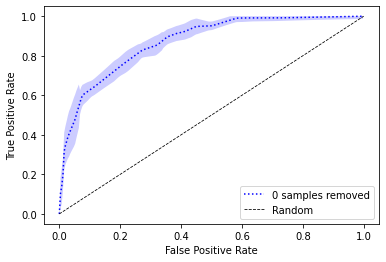

  0%|          | 0/115 [00:00<?, ?it/s]

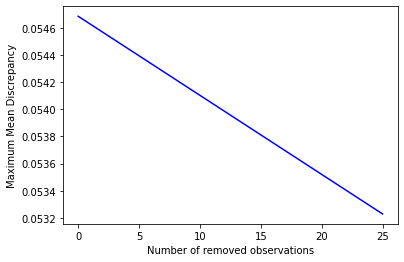

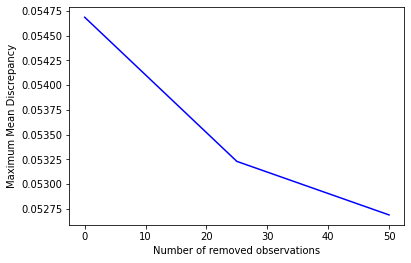

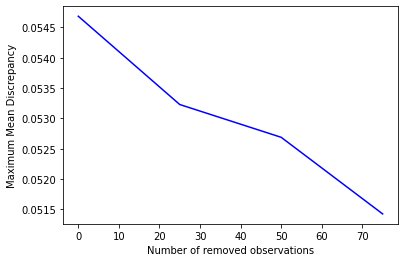

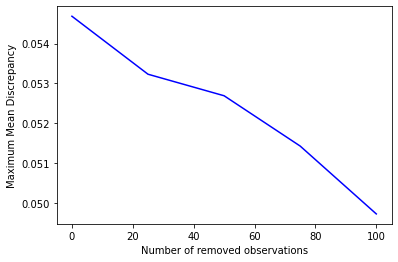

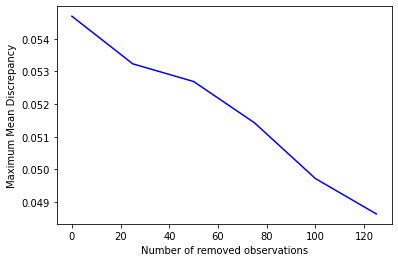

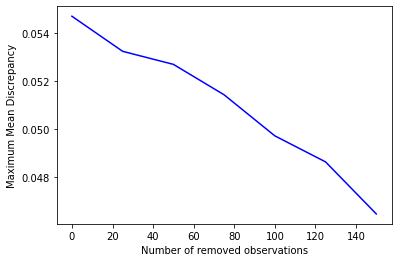

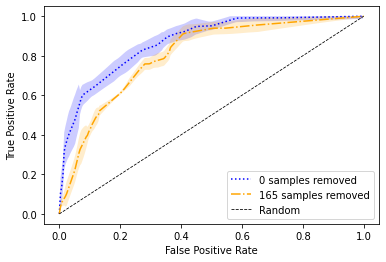

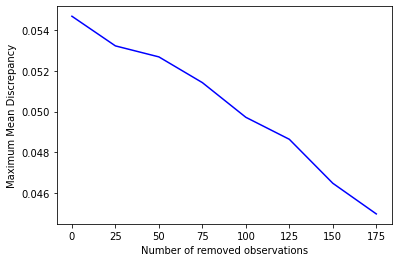

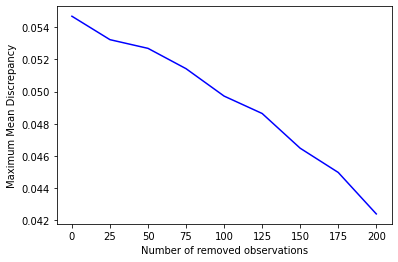

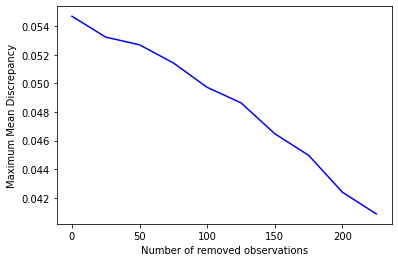

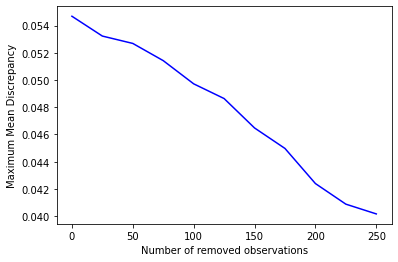

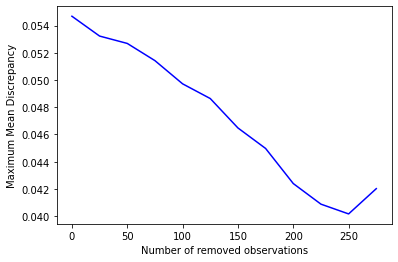

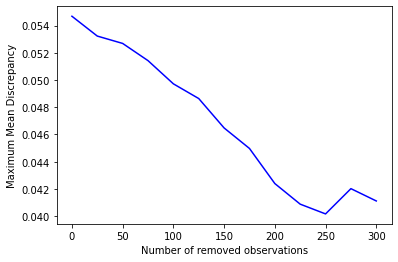

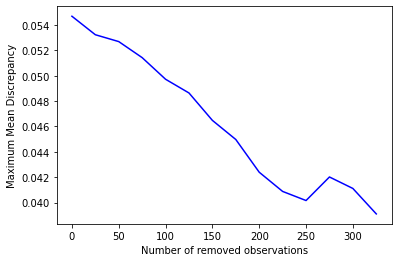

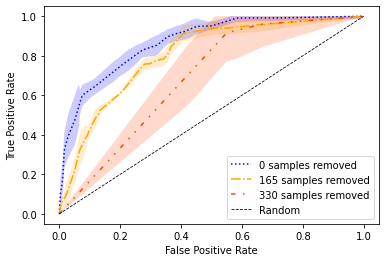

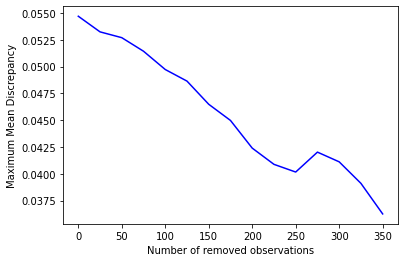

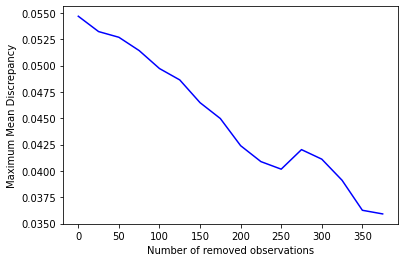

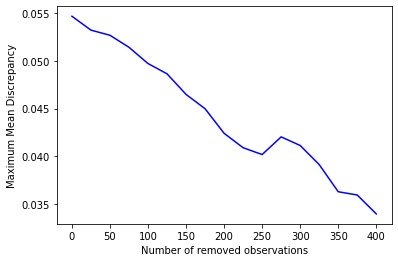

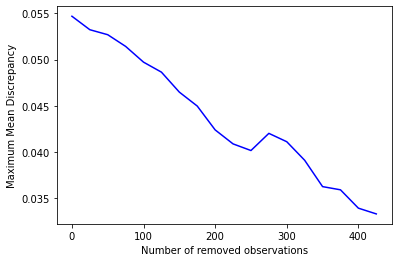

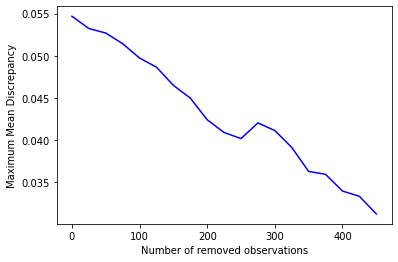

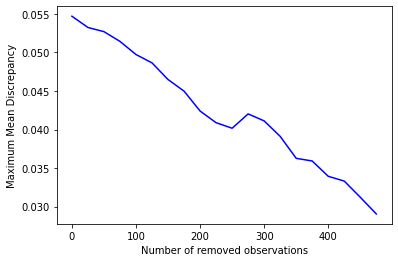

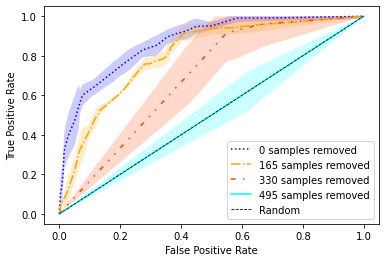

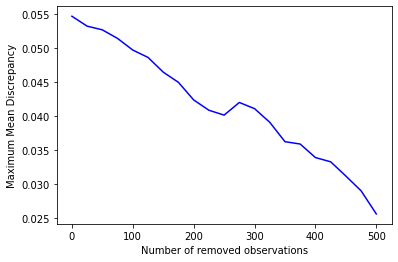

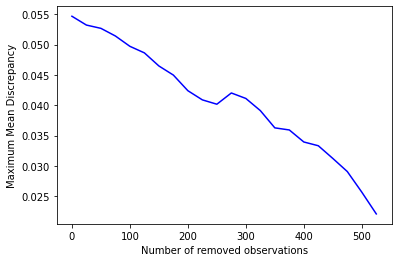

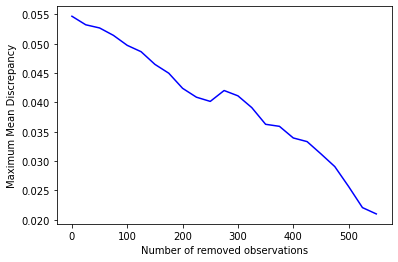

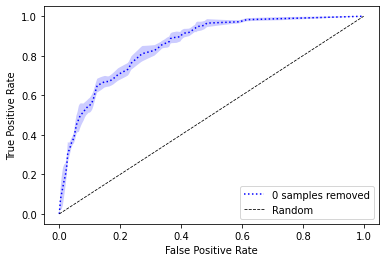

  0%|          | 0/115 [00:00<?, ?it/s]

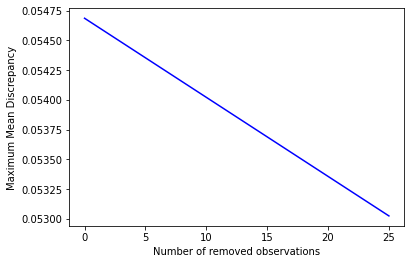

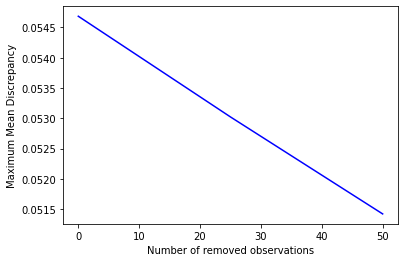

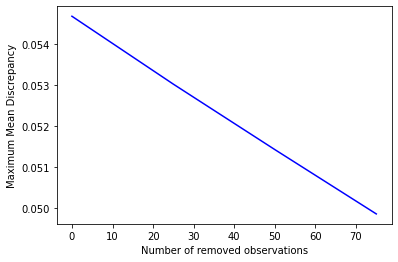

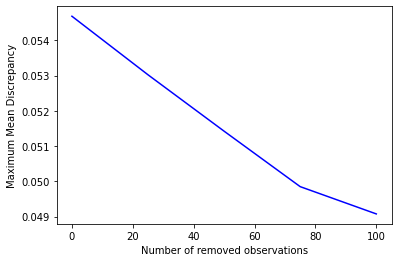

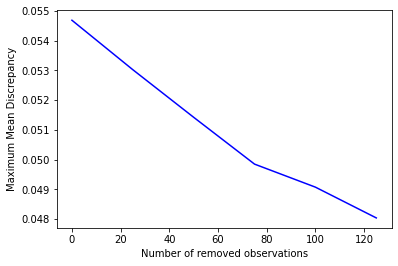

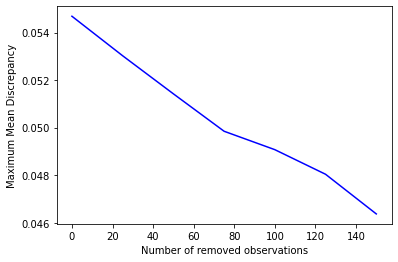

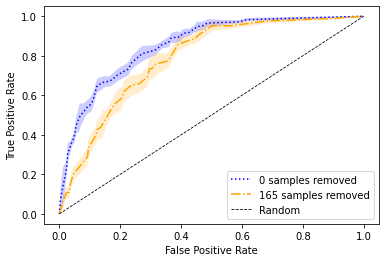

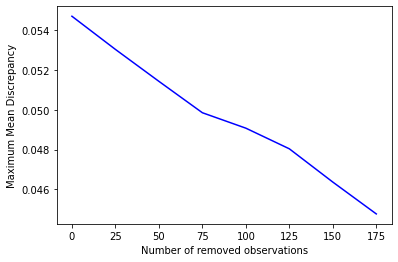

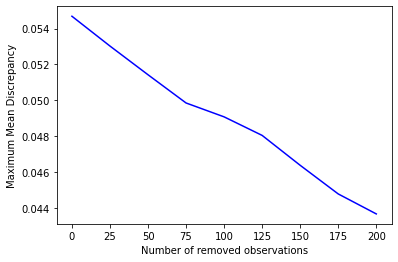

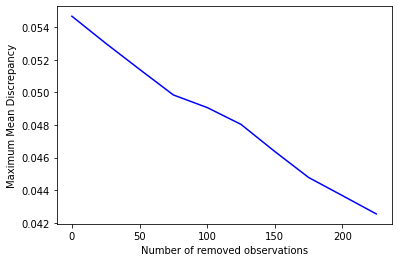

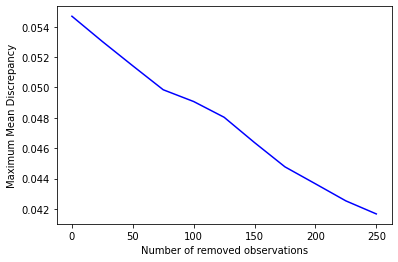

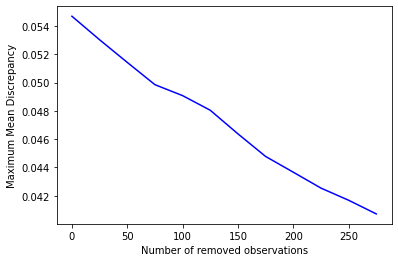

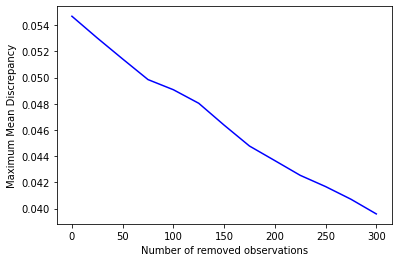

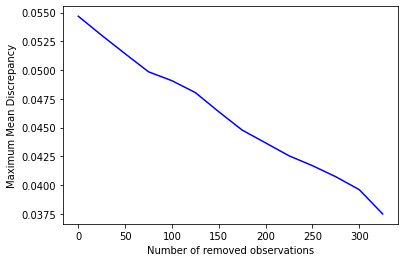

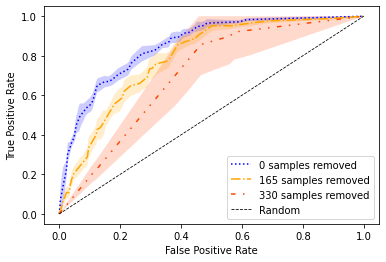

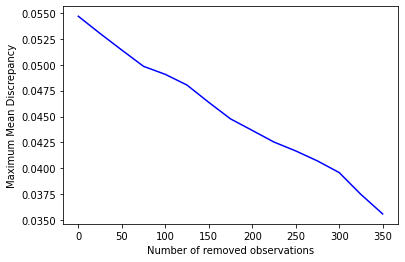

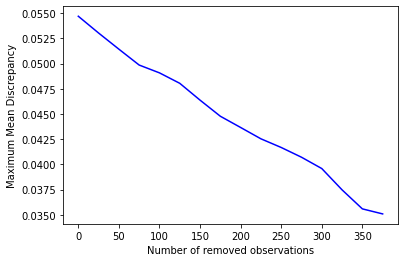

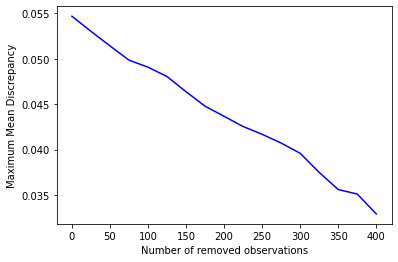

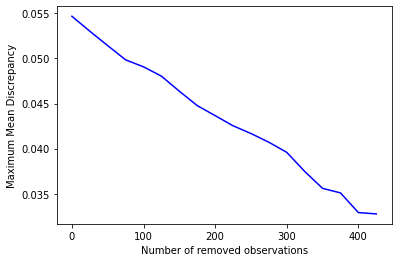

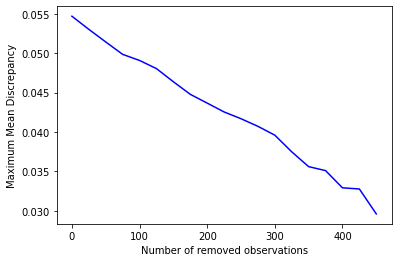

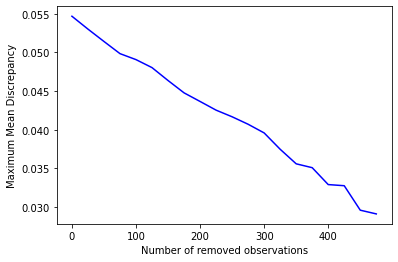

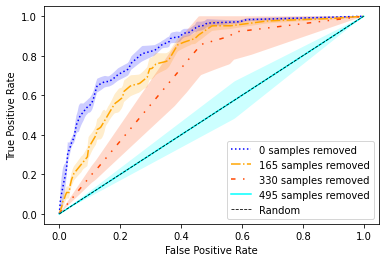

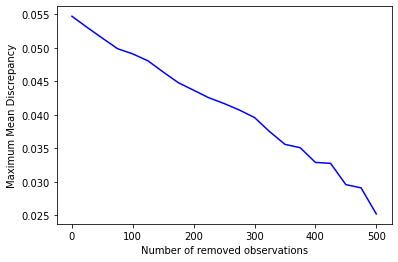

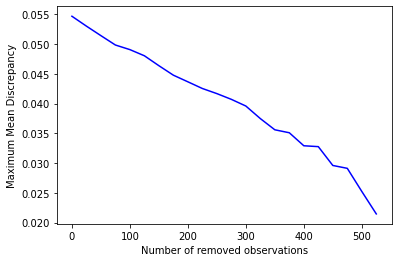

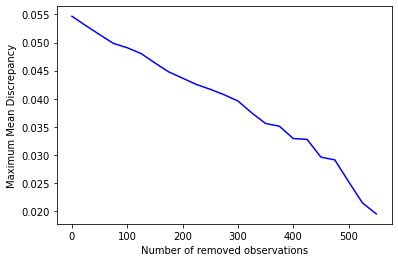

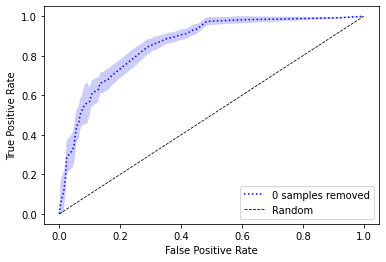

  0%|          | 0/115 [00:00<?, ?it/s]

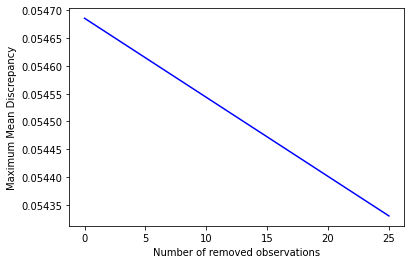

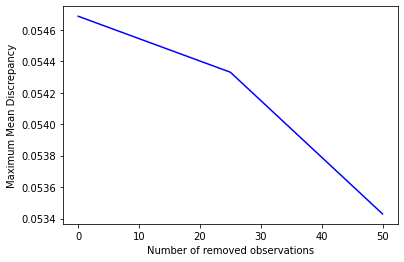

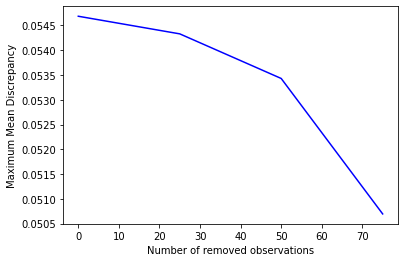

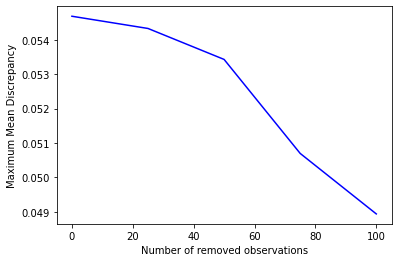

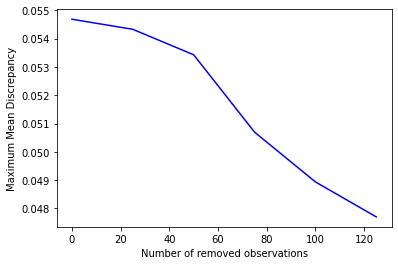

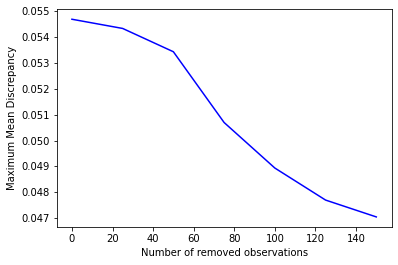

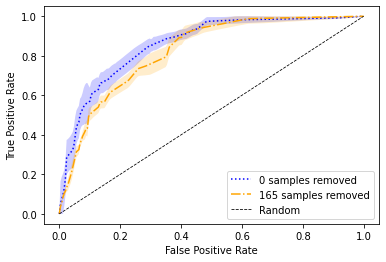

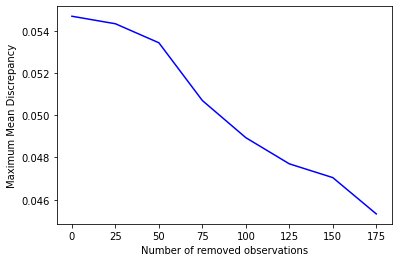

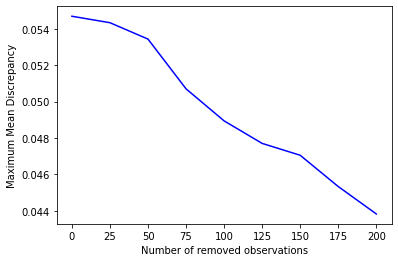

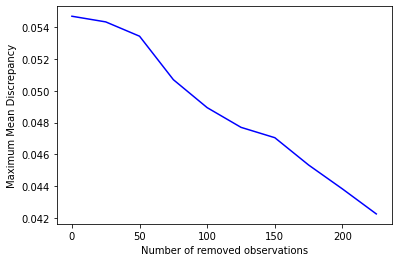

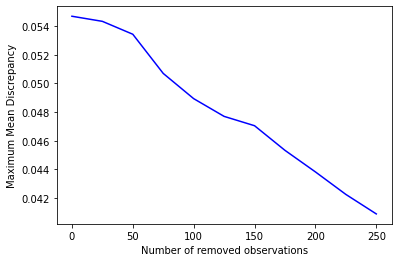

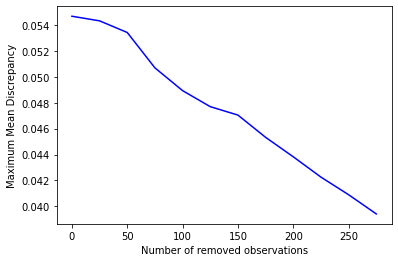

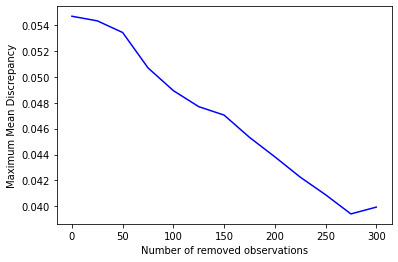

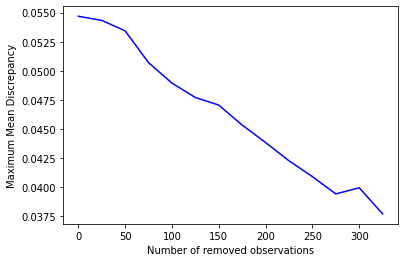

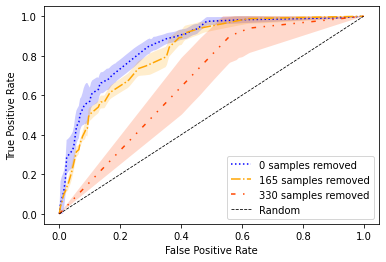

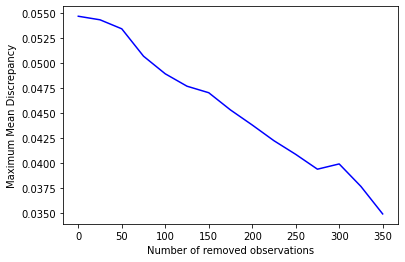

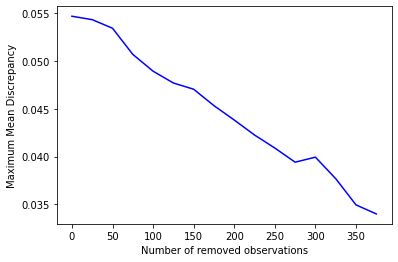

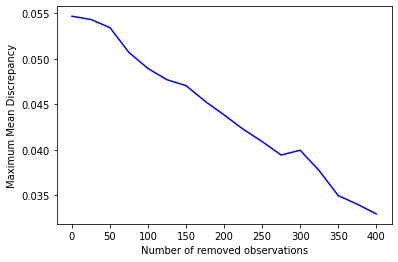

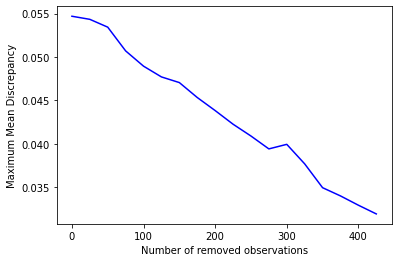

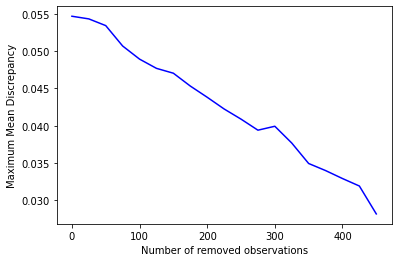

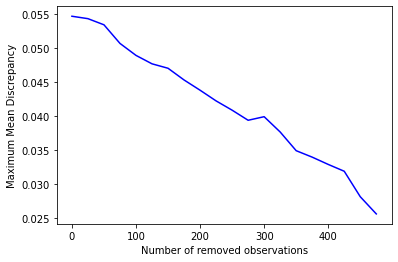

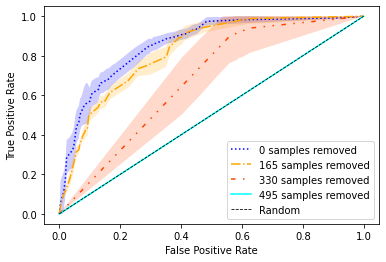

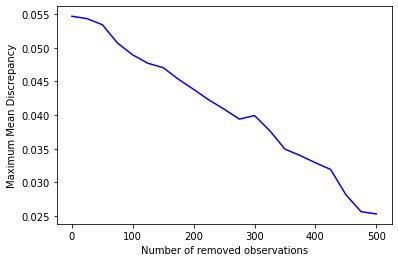

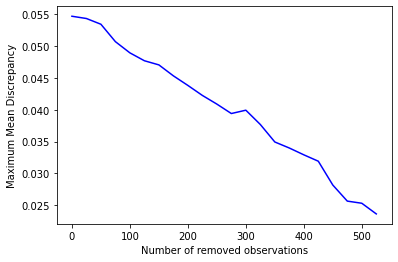

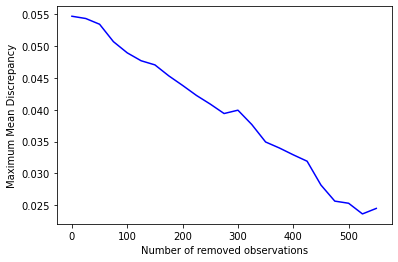

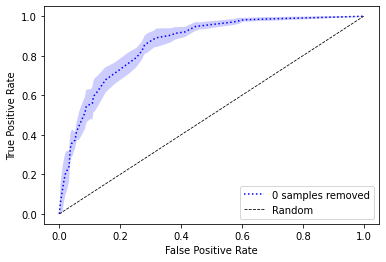

  0%|          | 0/115 [00:00<?, ?it/s]

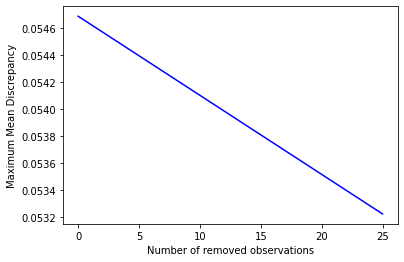

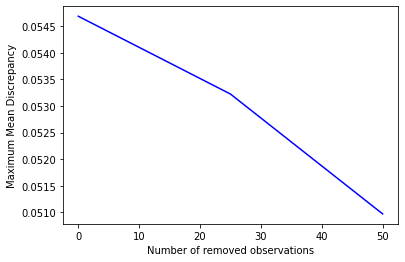

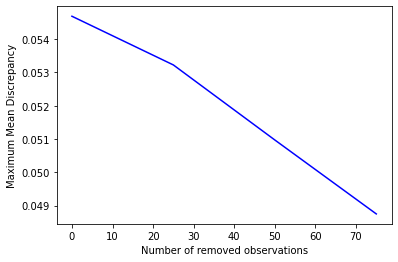

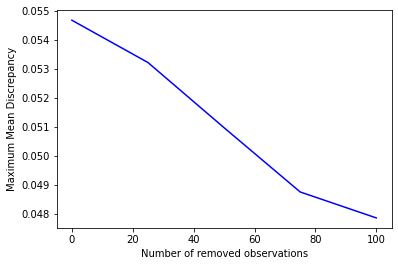

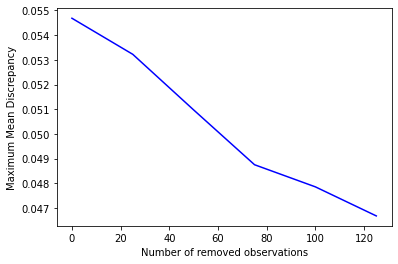

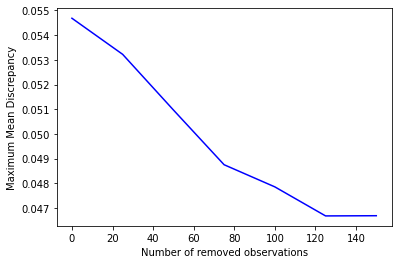

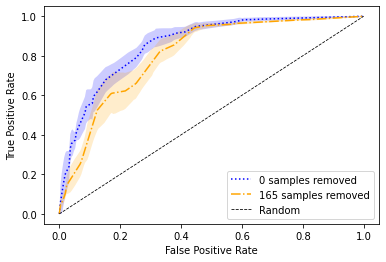

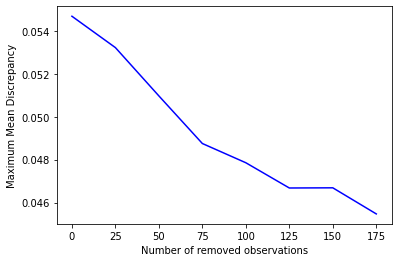

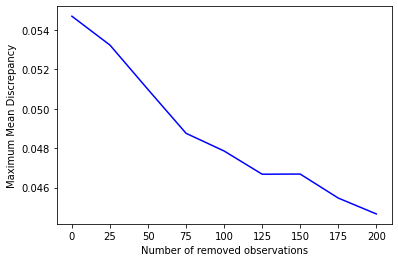

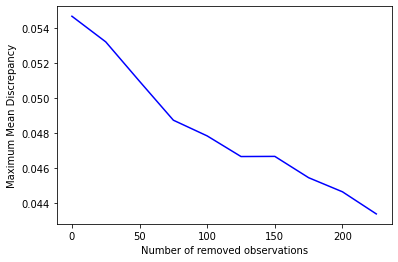

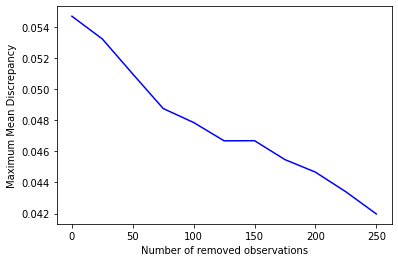

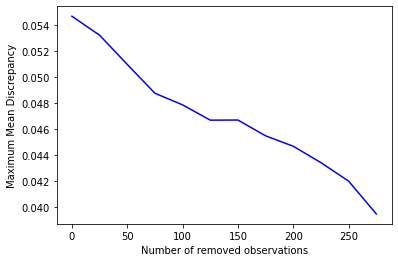

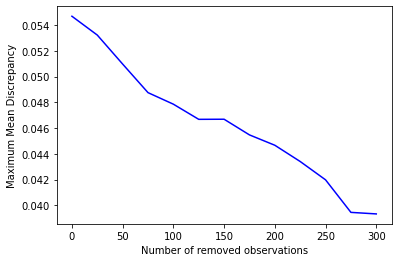

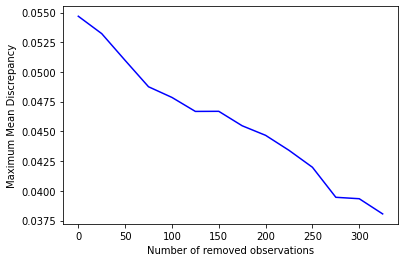

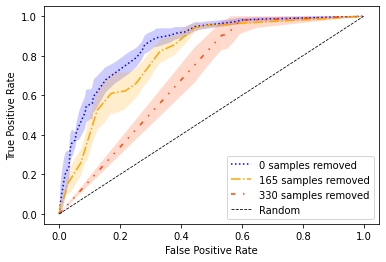

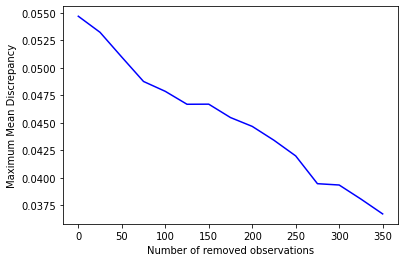

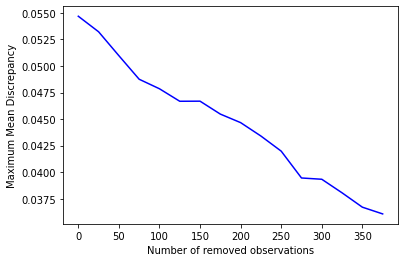

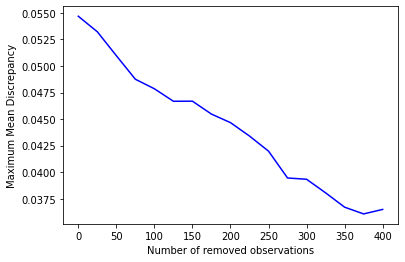

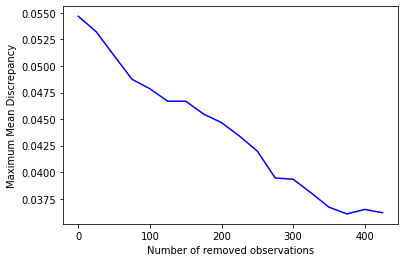

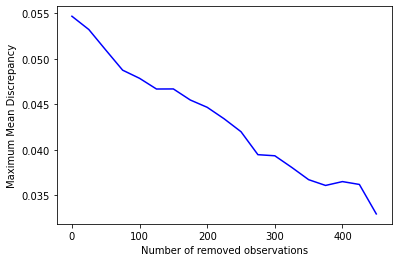

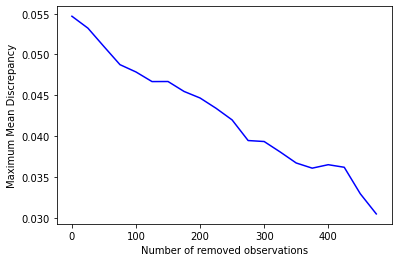

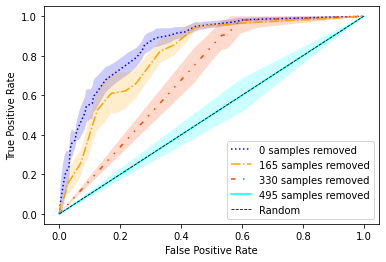

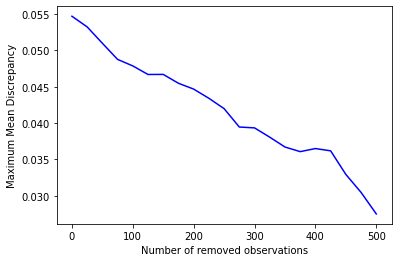

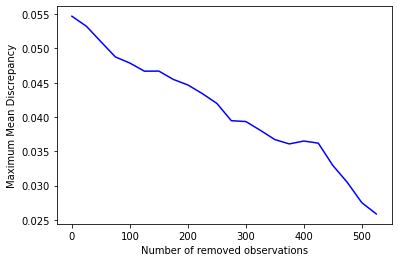

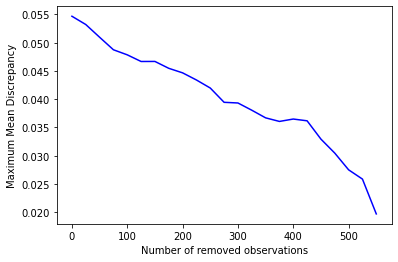

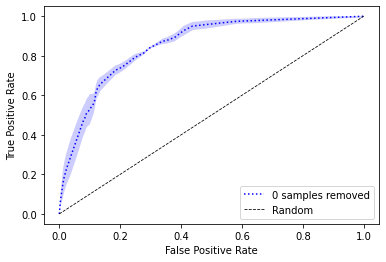

  0%|          | 0/115 [00:00<?, ?it/s]

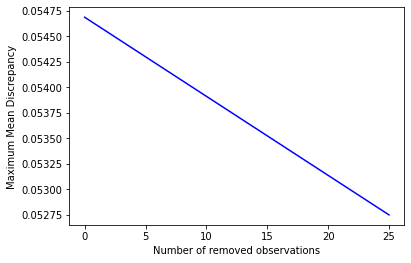

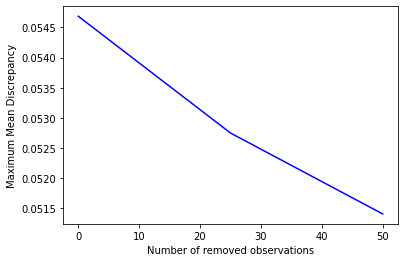

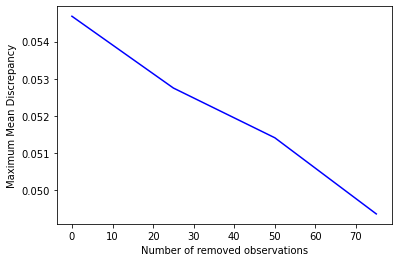

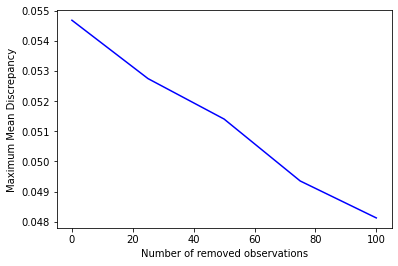

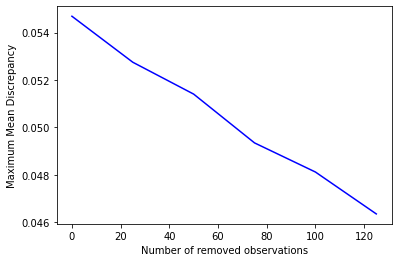

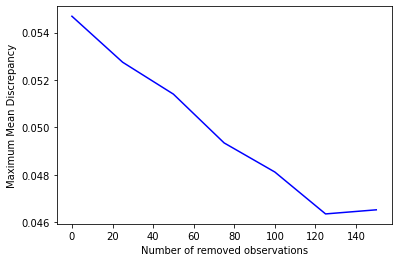

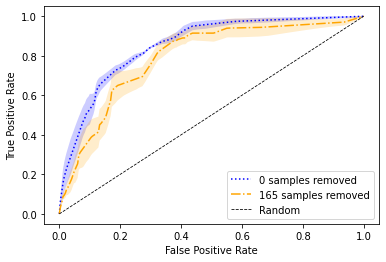

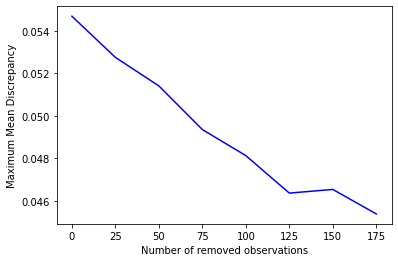

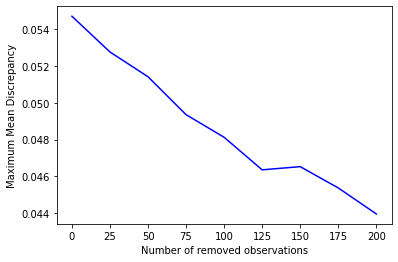

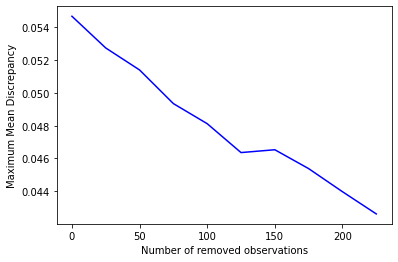

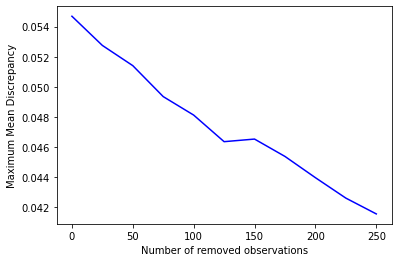

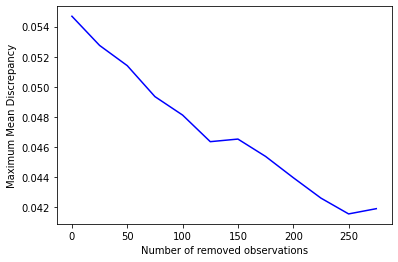

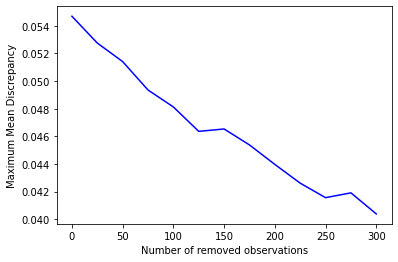

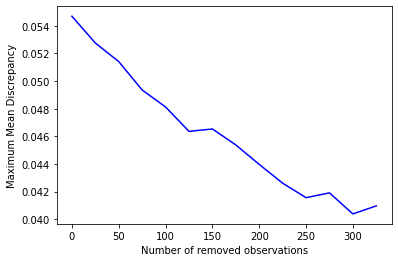

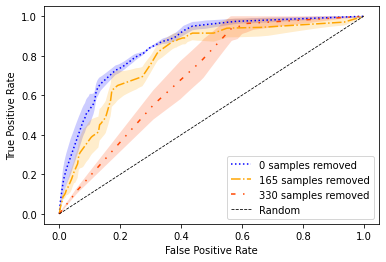

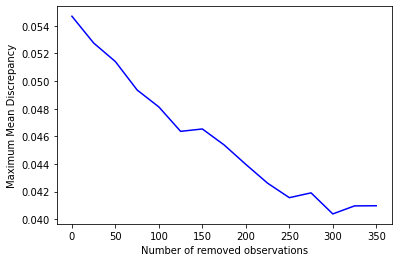

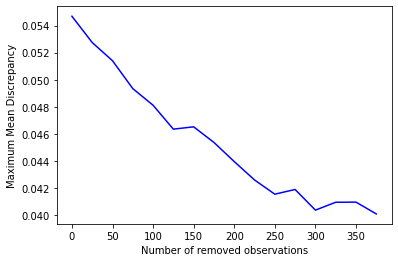

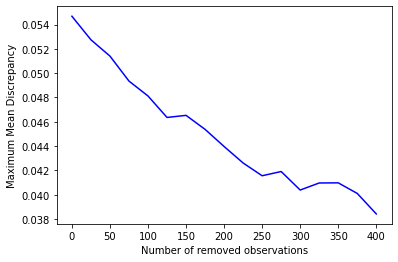

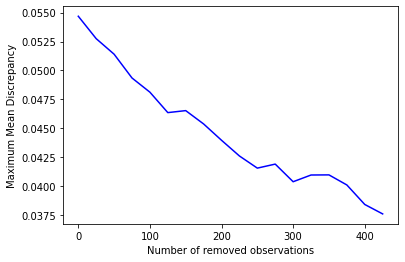

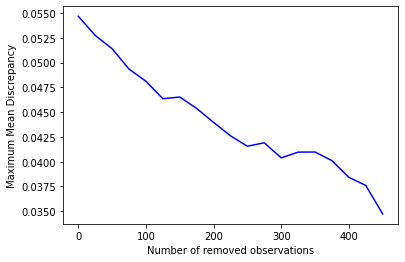

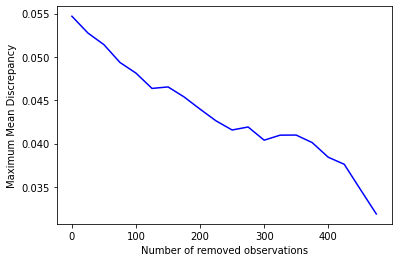

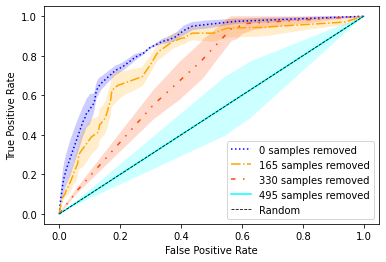

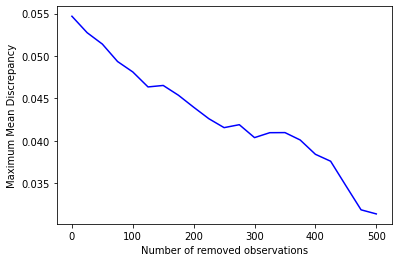

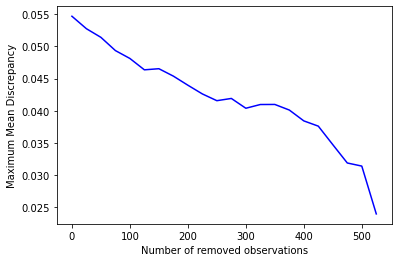

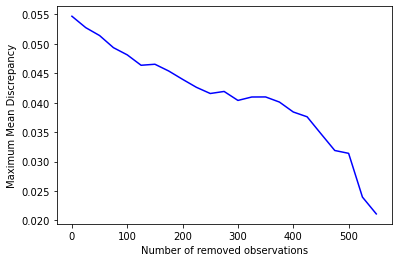

In [147]:
number_of_mrs = 5
mrs_list = []
drop = 5
number_of_splits = 5
cv = 5
test_size = 0.3
number_of_iterations = int(len(scaled_allensbach[scaled_allensbach['label'] == 1]) / drop) 
mmd_iteration = 700

for _ in tqdm(range(number_of_mrs)):
    _, _, mrs, _, _ = repeated_MRS(scaled_allensbach, allensbach_columns, 
                                                         number_of_splits=number_of_splits,
                            n_drop=drop, test_size=test_size, cv=cv, directory='',
                                                 number_of_iterations=number_of_iterations)
    mrs_list.append(mrs)

### Save MRS list

In [148]:
for mrs in mrs_list:
    mrs[allensbach_columns] = allensbach_scaler.inverse_transform(mrs[allensbach_columns])

In [168]:
pickle.dump(mrs_list, open("results/mrs_list", 'wb'))

### Load MRS list

In [177]:
mrs_list = pickle.load(open("results/mrs_list", 'rb'))
all_mrs_elements = pd.concat(mrs_list)

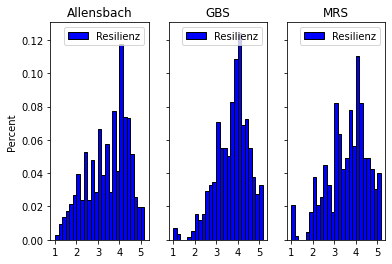

In [178]:
from scipy.stats import norm
allensbach_gbs = allensbach[allensbach['label'] == 1]
allensbach_without_gbs = allensbach[allensbach['label'] == 0]
bins = []
for i in range(6, 32):
    bins.append(round(i/6, 6))

value = 'Resilienz'
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, sharex=True)

weights_gbs = np.ones_like(allensbach_gbs[value]) / len(allensbach_gbs[value])
weights_mrs = np.ones_like(all_mrs_elements[value]) / len(all_mrs_elements[value])
weights_allensbach = np.ones_like(allensbach_without_gbs[value]) / len(allensbach_without_gbs[value])


allensbach_without_gbs[value] = round(allensbach_without_gbs[value], 6)
allensbach_without_gbs.plot.hist(y=value, bins=bins, ax=ax1, weights=weights_allensbach, ec='black')

allensbach_gbs[value] = round(allensbach_gbs[value], 6)
allensbach_gbs.plot.hist(y=value, bins=bins, ax=ax2, weights=weights_gbs, ec='black')

all_mrs_elements[value] = round(all_mrs_elements[value], 6)
all_mrs_elements.plot.hist(y=value, bins=bins, ax=ax3, weights=weights_mrs, ec='black')

ax2.set_title('GBS')
ax3.set_title('MRS')
ax1.set_title('Allensbach')
ax1.set_xticks([1, 2, 3, 4, 5])
ax1.set_ylabel('Percent')

file_directory = os.path.join(os.getcwd(), "final_results/statistic/")
os.makedirs(file_directory, exist_ok=True)
f.savefig(file_directory + f'/{value}_histogram.pdf')
f.show()

### Plot cumulative distribution function

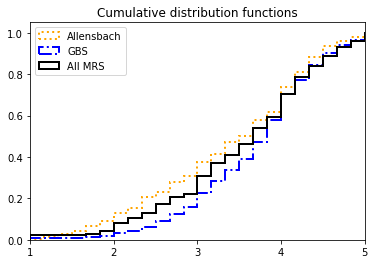

In [179]:
f, ax = plt.subplots(1, 1, sharey=True, sharex=True)

ax1.grid()

ax.hist(allensbach_without_gbs['Resilienz'], bins=bins, density=True, histtype='step',
                           cumulative=True, label='Allensbach', color='orange', linewidth=2,
       linestyle=':')
ax.hist(allensbach_gbs['Resilienz'], bins=bins,  density=True, histtype='step',
                           cumulative=True, color='blue', linestyle='-.', label='GBS', linewidth=2)
ax.hist(all_mrs_elements['Resilienz'], bins=bins, density=True, histtype='step',
                           cumulative=True, color='black', linestyle='-', label='All MRS', linewidth=2)

ax.legend(loc="upper left")
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_title('Cumulative distribution functions')
plt.xlim(1, 5)
plt.savefig(file_directory + f'/{value}_comulative_density.pdf')

plt.show()

In [180]:
y, X = dmatrices('Wahlteilnahme ~ Resilienz', data=allensbach_gbs, return_type='dataframe')
model_gbs = sm.Logit(y, X)
results_gbs = model_gbs.fit() 

restricted_model_gbs = sm.Logit(y, X.drop(columns='Resilienz'))
restricted_results_gbs = restricted_model_gbs.fit() 
 
y, X = dmatrices('Wahlteilnahme ~ Resilienz', data=all_mrs_elements, return_type='dataframe')
model_all = sm.Logit(y, X)
results_all = model_all.fit() 

restricted_model_all = sm.Logit(y, X.drop(columns='Resilienz'))
restricted_results_all = restricted_model_all.fit() 

Optimization terminated successfully.
         Current function value: 0.198294
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.198769
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.234578
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.236570
         Iterations 7


In [181]:
results_gbs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Wahlteilnahme   No. Observations:                  579
Model:                          Logit   Df Residuals:                      577
Method:                           MLE   Df Model:                            1
Date:                Fri, 06 Aug 2021   Pseudo R-squ.:                0.002392
Time:                        16:25:59   Log-Likelihood:                -114.81
converged:                       True   LL-Null:                       -115.09
Covariance Type:            nonrobust   LLR p-value:                    0.4581
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2887      0.880      2.602      0.009       0.565       4.013
Resilienz      0.1807      0.241      0.751      0.453      -0.291       0.652
==============================================================================
"""

### Create mean models

### Likelihood-ratio test GBS

In [182]:
loglikelihood_full = results_gbs.llf
loglikelihood_restr = restricted_results_gbs.llf
lrstat = -2*(loglikelihood_restr - loglikelihood_full)
lr_pvalue_gbs = stats.chi2.sf(lrstat, df=1)

### Log Likelihood test MRS list

In [183]:
loglikelihood_full = results_all.llf
loglikelihood_restr = restricted_results_all.llf
lrstat = -2*(loglikelihood_restr - loglikelihood_full)
lr_pvalue_all = stats.chi2.sf(lrstat, df=1)

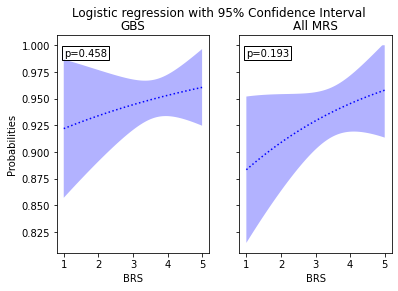

In [184]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)
f.suptitle('Logistic regression with 95% Confidence Interval')
ax1.set_title(f'GBS')
ax1.set_ylabel('Probabilities')
ax1.set_xlabel('BRS')
ax1.set_xticks([1, 2, 3, 4, 5])

intercept_gbs, slope_gbs = results_gbs.params
x_line = np.linspace(1, 5, 200)
x = allensbach_gbs['Resilienz']
y = allensbach_gbs['Wahlteilnahme']
log_odds  = slope_gbs * x_line + intercept_gbs
y_line = 1 / (1+ np.exp(-log_odds))
y_model = results_gbs.predict()
x_mean = np.mean(x)
y_mean = np.mean(y)
n = x.size                        # number of samples
m = 1                             # number of parameters
dof = n - m  
t = stats.t.ppf(0.975, dof)
residual = y - y_model
std_error = (np.sum(residual**2) / dof)**.5
# confidence interval
ci = t * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
ci_high = [1 if i>1 else i for i in y_line + ci]
ax1.plot(x_line, y_line)
ax1.fill_between(x_line, ci_high, y_line - ci, alpha=0.3)

intercept_all, slope_all = results_all.params
x = all_mrs_elements['Resilienz']
y = all_mrs_elements['Wahlteilnahme']
log_odds  = slope_all * x_line + intercept_all
y_line = 1 / (1 + np.exp(-log_odds))
y_model = results_all.predict()
x_mean = np.mean(x)
y_mean = np.mean(y)
n = x.size                        # number of samples
m = 1                             # number of parameters
dof = n - m  
t = stats.t.ppf(0.975, dof)
residual = y - y_model
std_error = (np.sum(residual**2) / dof)**.5
# confidence interval
ci = t * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
ci_low = y_line - ci
ci_high = [1 if i>1 else i for i in y_line + ci]
ax2.set_title('All MRS')
ax2.set_xlabel('BRS');
ax2.plot(x_line, y_line)
ax2.fill_between(x_line, ci_low, ci_high, alpha=0.3)

# Show the plot
ax1.text(1, 0.99, f'p={round(lr_pvalue_gbs, 3)}',
        bbox=dict(facecolor='none', edgecolor='black', pad=2))
ax2.text(1, 0.99, f'p={round(lr_pvalue_all, 3)}', 
         bbox=dict(facecolor='none', edgecolor='black', pad=2))
f.savefig(file_directory + '/glm_brs_wahlteilnahme.pdf')
f.show()